##  Data cleaning & Exploratory Analysis Model Building
#### Highlights: Bi-Feature, Multi-Class Machine Learning & Multivariate Charts
#### Retrospective Observational Study
#### Correlation Analysis
#### Model Building & Evaluation


*Machine Learning is utilized during customer_df data clean & transformation. Order of modifications:*
* *credit_df*
* *customer_df*
* *loan_df*

### Research Questions:
* Does income range placement affect loan condition qualities?
* Do certain occupations receive better loan conditions over others? Are term lengths evenly distributed?*
* Are there variables that constitute a higher Prosper Score?

## Data Clean & Transformation
Removing unneccessary attributes and defining parameters of the loan dataframe such as size, amount of nulls, duplicates, etc.

In [1]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import numpy as np
import sklearn.metrics as metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import make_column_transformer as mct
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split



#set_config(transform_output = 'pandas')
#pd.set_option('display.precision', 3)
original_df = pd.read_csv(r'C:\Users\saisu\Desktop\Python & Finance\P2P Project\propsper.csv', low_memory=False)

##ListingCategory (numeric),DebtToIncomeRatio,LoanOriginalAmount=amount_borrowed,MonthlyLoanPayment=listing_monthly_payment  CreditGrade= prosper_rating, EmploymentStatusDuration=months_employed,TotalCreditLinespast7years=credit_lines_last7_years
columns_to_keep = [
    'prosper_rating', 'term', 'loan_status', 'borrower_apr', 'borrower_rate',
    'prosper_score',
    'occupation', 'employment_status_description', 'months_employed',
     'open_credit_lines',
    'credit_lines_last7_years', 'total_inquiries', 'current_delinquencies',
    'amount_delinquent', 'bankcard_utilization', 'total_trade_items',
     'income_range', 'income_verifiable', 'loan_number',
    'amount_borrowed', 'listing_monthly_payment','prosper_score'
]
original_df = original_df[columns_to_keep]
original_df.head(2)

,prosper_rating,term,loan_status,borrower_apr,borrower_rate,prosper_score,occupation,employment_status_description,months_employed,open_credit_lines,...,current_delinquencies,amount_delinquent,bankcard_utilization,total_trade_items,income_range,income_verifiable,loan_number,amount_borrowed,listing_monthly_payment,prosper_score
0,C,60,4,0.17618,0.1526,6.0,Other,Employed,16.0,3.0,...,0.0,0.0,0.66,5.0,3,True,254354,12000.0,287.12,6.0
1,A,36,4,0.10989,0.0819,5.0,NaN,Other,50.0,7.0,...,0.0,0.0,0.62,28.0,3,True,254360,6000.0,188.54,5.0


### *Ceremonial PK Integrity Check!*
Dataset cotains attribute LoanNumbers. Each of these should be unique as there can't be more than one instance of a loan. This functions as the business key/primary key for this data set. Duplicates will be dropped for distribution accuracy.

In [2]:
print(original_df.shape)
loan_duplicate = original_df.loc[:, 'loan_number'].duplicated().sum()
original_df = original_df.drop_duplicates(subset='loan_number', ignore_index=True)
loan_duplicate_2 = original_df.loc[:, 'loan_number'].duplicated().sum()
print(f'Duplicate count: {loan_duplicate}\nAfter drop count: {loan_duplicate_2}')
print(original_df.shape)

(604331, 22)
Duplicate count: 0
After drop count: 0
(604331, 22)


#### Creating relational dimension tables for organization purposes.

In [3]:
# Credit related sub-table
credit_columns = [
    'prosper_rating', 'prosper_score','open_credit_lines', 'credit_lines_last7_years',
    'total_inquiries', 'current_delinquencies', 'amount_delinquent', 'bankcard_utilization'
]

credit_df = original_df[credit_columns]
print(credit_df.shape)
credit_df.head(5)

(604331, 9)


,prosper_rating,prosper_score,prosper_score,open_credit_lines,credit_lines_last7_years,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization
0,C,6.0,6.0,3.0,5.0,1.0,0.0,0.0,0.66
1,A,5.0,5.0,7.0,28.0,3.0,0.0,0.0,0.62
2,B,8.0,8.0,8.0,27.0,14.0,0.0,0.0,0.74
3,A,9.0,9.0,8.0,14.0,6.0,1.0,0.0,0.52
4,D,7.0,7.0,11.0,27.0,15.0,0.0,0.0,0.93


In [4]:
# Identify and drop duplicate columns
credit_df = credit_df.loc[:, ~credit_df.columns.duplicated()]

# Verify the DataFrame after removing duplicate columns
print(credit_df.head())

  prosper_rating  prosper_score  open_credit_lines  credit_lines_last7_years  \
0              C            6.0                3.0                       5.0   
1              A            5.0                7.0                      28.0   
2              B            8.0                8.0                      27.0   
3              A            9.0                8.0                      14.0   
4              D            7.0               11.0                      27.0   

   total_inquiries  current_delinquencies  amount_delinquent  \
0              1.0                    0.0                0.0   
1              3.0                    0.0                0.0   
2             14.0                    0.0                0.0   
3              6.0                    1.0                0.0   
4             15.0                    0.0                0.0   

   bankcard_utilization  
0                  0.66  
1                  0.62  
2                  0.74  
3                  0.52  
4   

In [5]:
# Loan related sub-table
loan_columns = [
    'term', 'loan_status', 'borrower_apr', 'borrower_rate',
     'loan_number', 'amount_borrowed',
    'listing_monthly_payment'
]
loan_df = original_df[loan_columns]
print(loan_df.shape)

(604331, 7)


In [6]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604331 entries, 0 to 604330
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   term                     604331 non-null  int64  
 1   loan_status              604331 non-null  int64  
 2   borrower_apr             604331 non-null  float64
 3   borrower_rate            604331 non-null  float64
 4   loan_number              604331 non-null  int64  
 5   amount_borrowed          604331 non-null  float64
 6   listing_monthly_payment  604331 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 32.3 MB


In [7]:
# Customer related sub-table
customer_columns = [
    'prosper_score', 'occupation', 'employment_status_description', 'months_employed',
    'total_trade_items', 'income_range', 'income_verifiable'
]

customer_df = original_df[customer_columns]
print(customer_df.shape)

(604331, 8)


In [8]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604331 entries, 0 to 604330
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   prosper_score                  600779 non-null  float64
 1   prosper_score                  600779 non-null  float64
 2   occupation                     567334 non-null  object 
 3   employment_status_description  604331 non-null  object 
 4   months_employed                603117 non-null  float64
 5   total_trade_items              220242 non-null  float64
 6   income_range                   604331 non-null  int64  
 7   income_verifiable              604326 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 36.9+ MB


#### With the tables now organized, they are going to be individually examined for optimal data integrity.
#### Starting with credit dimension table.

In [9]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604331 entries, 0 to 604330
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   prosper_rating            604331 non-null  object 
 1   prosper_score             600779 non-null  float64
 2   open_credit_lines         220257 non-null  float64
 3   credit_lines_last7_years  220255 non-null  float64
 4   total_inquiries           220242 non-null  float64
 5   current_delinquencies     220255 non-null  float64
 6   amount_delinquent         220255 non-null  float64
 7   bankcard_utilization      220257 non-null  float64
dtypes: float64(7), object(1)
memory usage: 36.9+ MB


In [10]:
# Calculate missing value percentages for each column
missing_percentage = (credit_df.isnull().mean() * 100).round(2)

# Display missing value percentages
print("\nMissing Value Percentages:")
print(missing_percentage)


Missing Value Percentages:
prosper_rating               0.00
prosper_score                0.59
open_credit_lines           63.55
credit_lines_last7_years    63.55
total_inquiries             63.56
current_delinquencies       63.55
amount_delinquent           63.55
bankcard_utilization        63.55
dtype: float64


Remove and impute missing value for: prosper_score

In [11]:
def mode_col_imputer(df, col):
    df_copy = df.copy()
    simple_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    simple_imputed = simple_imp.fit_transform(df_copy[[col]])
    df_copy[[col]] = simple_imputed.astype(object)
    return df_copy

# Calling mode imputer for credit table
for col in credit_df.columns:
    credit_df_imputed = mode_col_imputer(credit_df, col)
    credit_df = credit_df_imputed
    credit_df_nulls = credit_df[col].isnull().sum()
    print(f'NULLS after mode imputation: {credit_df_nulls}\n{col}')

NULLS after mode imputation: 0
prosper_rating
NULLS after mode imputation: 0
prosper_score
NULLS after mode imputation: 0
open_credit_lines
NULLS after mode imputation: 0
credit_lines_last7_years
NULLS after mode imputation: 0
total_inquiries
NULLS after mode imputation: 0
current_delinquencies
NULLS after mode imputation: 0
amount_delinquent
NULLS after mode imputation: 0
bankcard_utilization


In [12]:
credit_df.sample(5)

,prosper_rating,prosper_score,open_credit_lines,credit_lines_last7_years,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization
578918,A,11.0,8.0,19.0,3.0,0.0,0.0,0.0
301553,B,8.0,8.0,19.0,3.0,0.0,0.0,0.0
388795,C,8.0,8.0,19.0,3.0,0.0,0.0,0.0
255202,C,8.0,8.0,19.0,3.0,0.0,0.0,0.0
589128,A,9.0,8.0,19.0,3.0,0.0,0.0,0.0


#### Checking accuracy of outliers in each credit table attribute. Non-valid outliers will be replaced with the mean of that specific column to strengthen data integrity levels.

In [13]:
def outlier_check(df, col):
    sorted = df[col].sort_values()
    max = sorted.head(2)
    min = sorted.tail(2)
    return max, min

for col in credit_df.columns:
    credit_df_min, credit_df_max = outlier_check(credit_df, col)
    string = f'MIN:\n{credit_df_min}\nMAX:\n{credit_df_max}'
    print(string)

MIN:
302165    A
448176    A
Name: prosper_rating, dtype: object
MAX:
495576    HR
219999    HR
Name: prosper_rating, dtype: object
MIN:
108879    2.0
101515    2.0
Name: prosper_score, dtype: object
MAX:
493021    12.0
495478    12.0
Name: prosper_score, dtype: object
MIN:
202008    0.0
208943    0.0
Name: open_credit_lines, dtype: object
MAX:
89269     65.0
196857    67.0
Name: open_credit_lines, dtype: object
MIN:
212457    0.0
195132    0.0
Name: credit_lines_last7_years, dtype: object
MAX:
90289     123.0
202954    126.0
Name: credit_lines_last7_years, dtype: object
MIN:
125485    0.0
92641     0.0
Name: total_inquiries, dtype: object
MAX:
205586    87.0
195126    89.0
Name: total_inquiries, dtype: object
MIN:
0         0.0
402882    0.0
Name: current_delinquencies, dtype: object
MAX:
126783    45.0
27490     55.0
Name: current_delinquencies, dtype: object
MIN:
0         0.0
402882    0.0
Name: amount_delinquent, dtype: object
MAX:
171082    494488.0
148969    512118.0
Name: amoun

In [14]:
credit_df.describe()

,prosper_rating,prosper_score,open_credit_lines,credit_lines_last7_years,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization
count,604331,604331.0,604331.0,604331.0,604331.0,604331.0,604331.0,604331.0
unique,7,11.0,61.0,114.0,67.0,27.0,8633.0,130.0
top,C,11.0,8.0,19.0,3.0,0.0,0.0,0.0
freq,162052,98478.0,404791.0,391684.0,413180.0,569845.0,576980.0,387926.0


#### The outlier validations below are valid unless specified otherwise.

In [15]:
credit_df.query('credit_lines_last7_years > 100').sort_values(by='credit_lines_last7_years').tail(5)

,prosper_rating,prosper_score,open_credit_lines,credit_lines_last7_years,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization
71689,C,9.0,41.0,118.0,16.0,0.0,0.0,0.22
211861,A,11.0,44.0,121.0,13.0,0.0,0.0,0.18
3521,B,9.0,32.0,123.0,7.0,0.0,0.0,0.26
90289,D,4.0,35.0,123.0,0.0,0.0,0.0,0.74
202954,E,3.0,56.0,126.0,19.0,0.0,0.0,0.43


In [16]:
credit_df.query('current_delinquencies > 40').sort_values(by='current_delinquencies').tail(5)

,prosper_rating,prosper_score,open_credit_lines,credit_lines_last7_years,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization
126783,B,11.0,11.0,66.0,1.0,45.0,4801.0,0.5
27490,C,4.0,4.0,68.0,4.0,55.0,13090.0,0.5


In [17]:
credit_df.query('amount_delinquent > 200000').sort_values(by='amount_delinquent').tail(5)

,prosper_rating,prosper_score,open_credit_lines,credit_lines_last7_years,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization
105419,D,4.0,7.0,22.0,12.0,5.0,292909.0,0.62
24376,A,9.0,13.0,31.0,5.0,2.0,296787.0,0.43
184022,B,8.0,17.0,41.0,4.0,7.0,315969.0,0.59
171082,C,11.0,6.0,26.0,5.0,2.0,494488.0,0.0
148969,A,10.0,16.0,31.0,7.0,1.0,512118.0,0.09


#### Customer table is now up on the chopping block for data dicing. Integrity is completely on the house.

In [18]:
customer_df.head()
# Identify and drop duplicate columns
customer_df = customer_df.loc[:, ~customer_df.columns.duplicated()]

# Verify the DataFrame after removing duplicate columns
print(customer_df.head())

# Importing necessary libraries
from sklearn.impute import SimpleImputer

# Define mode_col_imputer function
def mode_col_imputer(df, col):
    df_copy = df.copy()
    simple_imp = SimpleImputer(strategy='most_frequent')
    simple_imputed = simple_imp.fit_transform(df_copy[[col]])
    df_copy[[col]] = simple_imputed
    return df_copy

# Apply mode_col_imputer to 'prosper_score' column
customer_df = mode_col_imputer(customer_df, 'prosper_score')

# Check if there are any missing values left in 'prosper_score'
print("Missing values in 'prosper_score' after imputation:", customer_df['prosper_score'].isnull().sum())

# Check missing values in customer_df
missing_values = customer_df.isnull().sum()

# Print missing values
print("Missing values in customer_df:")
print(missing_values)



   prosper_score               occupation employment_status_description  \
0            6.0                    Other                      Employed   
1            5.0                      NaN                         Other   
2            8.0                      NaN                         Other   
3            9.0                    Other                      Employed   
4            7.0  Food Service Management                      Employed   

   months_employed  total_trade_items  income_range income_verifiable  
0             16.0                5.0             3              True  
1             50.0               28.0             3              True  
2            123.0               27.0             4              True  
3             82.0               14.0             4              True  
4            241.0               27.0             3              True  
Missing values in 'prosper_score' after imputation: 0
Missing values in customer_df:
prosper_score                   

#### Data type integrity inspect with mean & mode impute below. Will be compared to ML Model in later section.

In [19]:
customer_df.sample(5)

,prosper_score,occupation,employment_status_description,months_employed,total_trade_items,income_range,income_verifiable
13511,5.0,Sales - Commission,Employed,7.0,57.0,6,True
603482,8.0,NaN,Other,679.0,NaN,5,True
70583,7.0,NaN,Other,156.0,24.0,3,True
228521,10.0,Tradesman - Mechanic,Employed,202.0,NaN,4,True
288373,11.0,Other,Employed,58.0,NaN,5,True


#### Checking accuracy of outliers in each customer table attribute. Non-valid outliers will be replaced with the mean of that specific column to strengthen data integrity levels.

In [20]:
for col in customer_df.columns:
    customer_df_min, customer_df_max = outlier_check(customer_df, col)
    string = f'MIN:\n{customer_df_min}\nMAX:\n{customer_df_max}'
    print(string)

MIN:
108879    2.0
101515    2.0
Name: prosper_score, dtype: float64
MAX:
493021    12.0
495478    12.0
Name: prosper_score, dtype: float64
MIN:
454039    Accountant/CPA
547004    Accountant/CPA
Name: occupation, dtype: object
MAX:
604232    NaN
604261    NaN
Name: occupation, dtype: object
MIN:
0         Employed
391438    Employed
Name: employment_status_description, dtype: object
MAX:
148186    Self-employed
283038    Self-employed
Name: employment_status_description, dtype: object
MIN:
139928   -7.0
193225   -2.0
Name: months_employed, dtype: float64
MAX:
410102   NaN
526062   NaN
Name: months_employed, dtype: float64
MIN:
215092    2.0
208852    2.0
Name: total_trade_items, dtype: float64
MAX:
604329   NaN
604330   NaN
Name: total_trade_items, dtype: float64
MIN:
36215     1
229828    2
Name: income_range, dtype: int64
MAX:
427533    6
436682    6
Name: income_range, dtype: int64
MIN:
5656     False
52321    False
Name: income_verifiable, dtype: object
MAX:
597868    NaN
598394   

Who in their right mind applies for a loan with no funding to pay it back? Of course stupidity exists in the real world, but the proportion of this statistic must be further analyzed. It has a positive correlation to "Not Employed". Evidently, unemployed people have 2 options of indicating their financial status. By selecting the "Not Employed" option or inputting $0 as a funding amount. These identical categories are converted into one to prevent distribution distortion.

In [21]:
income_values = customer_df.income_range.value_counts()
print(f'BEFORE: {income_values}')
customer_df.loc[:, 'income_range'] = customer_df.replace('Not employed', '$0').replace('Not displayed', np.nan)
income_values2 = customer_df.income_range.value_counts()
print(f'\nAFTER: {income_values2}')

BEFORE: income_range
4    178276
3    156295
6    142944
5    111212
2     15603
1         1
Name: count, dtype: int64

AFTER: income_range
4    178276
3    156295
6    142944
5    111212
2     15603
1         1
Name: count, dtype: int64


In [22]:
income_values3 = f'NULL Values: {customer_df.income_range.isnull().sum()}'
print(income_values3)

NULL Values: 0


In [23]:
preimpute_customer = customer_df.copy()
# Customer_ML is replacing customer_df for chart analysis. Will contain model predictions instead of
# mode impute from SimpleImpute(). NULLs from preimpute_customer are removed in copy.
customer_ML = preimpute_customer.copy()
customer_ML['PK'] = customer_ML.index

# Identifying NULL behaving values in customer_ML and adding primary key attribute
add_col_ML = customer_ML.loc[customer_ML['months_employed']=='Not available'].copy()
add_col_ML['PK'] = add_col_ML.index
add_col_ML2 = customer_ML.loc[customer_ML['income_range']=='Not displayed'].copy()
add_col_ML2['PK'] = add_col_ML2.index

# Extract the "PK" column from each DataFrame
pk_series_1 = list(add_col_ML['PK'])
pk_series_2 = list(add_col_ML2['PK'])
pk_series_3 = list(customer_ML['PK'])
len_PK = f'Records in each PK subtable: {len(pk_series_1)} {len(pk_series_2)} {len(pk_series_3)}'
print(len_PK)

# Function to check if all PKs are in each other. False means all PKs are included
# Both tests pass the check
def PK_tester(df, df2):
    test_list = []
    for item in df:
        if item in df2:
            test_list.append(True)
        else:
            test_list.append(False)
    test = False in test_list
    print(test)

# Real tests
PK_input1 = PK_tester(pk_series_1, pk_series_2)
PK_input2 = PK_tester(pk_series_2, pk_series_3)

# Algorithm check. Should return True since pk_series_2 has more PKs and invalidates the conditional
PK_input3 = PK_tester(pk_series_2, pk_series_1)

# This indicates that all the 2 smaller tables are really subtables of the largest (pk_series_3)
# An ML_table will be created with the largest table moving forward

Records in each PK subtable: 0 0 604331
False
False
False


### Machine Learning (ML): Bi-Feature, Multi-Class Logistic Regression Algorithm

In [24]:

# Importing necessary libraries
from sklearn.impute import SimpleImputer

# Define mode_col_imputer function
def mode_col_imputer(df, col):
    df_copy = df.copy()
    simple_imp = SimpleImputer(strategy='most_frequent')
    simple_imputed = simple_imp.fit_transform(df_copy[[col]])
    df_copy[[col]] = simple_imputed
    return df_copy

# Apply mode_col_imputer to 'prosper_score' column
original_df = mode_col_imputer(original_df, 'prosper_score')

# Check if there are any missing values left in 'prosper_score'
print("Missing values in 'prosper_score' after imputation:", original_df['prosper_score'].isnull().sum())

original_df.head(5)


Missing values in 'prosper_score' after imputation: prosper_score    0
prosper_score    0
dtype: int64


,prosper_rating,term,loan_status,borrower_apr,borrower_rate,prosper_score,occupation,employment_status_description,months_employed,open_credit_lines,...,current_delinquencies,amount_delinquent,bankcard_utilization,total_trade_items,income_range,income_verifiable,loan_number,amount_borrowed,listing_monthly_payment,prosper_score
0,C,60,4,0.17618,0.1526,6.0,Other,Employed,16.0,3.0,...,0.0,0.0,0.66,5.0,3,True,254354,12000.0,287.12,6.0
1,A,36,4,0.10989,0.0819,5.0,NaN,Other,50.0,7.0,...,0.0,0.0,0.62,28.0,3,True,254360,6000.0,188.54,5.0
2,B,60,3,0.16052,0.1373,8.0,NaN,Other,123.0,8.0,...,0.0,0.0,0.74,27.0,4,True,254369,18000.0,416.31,8.0
3,A,36,4,0.10989,0.0819,9.0,Other,Employed,82.0,8.0,...,1.0,0.0,0.52,14.0,4,True,254372,3636.0,114.26,9.0
4,D,60,4,0.24328,0.2181,7.0,Food Service Management,Employed,241.0,11.0,...,0.0,0.0,0.93,27.0,3,True,254375,3000.0,82.53,7.0


In [25]:
# Apply mode_col_imputer to 'occupation' column
customer_df = mode_col_imputer(original_df, 'occupation')

# Check if there are any missing values left in 'prosper_score'
print("Missing values in 'occupation' after imputation:", original_df['occupation'].isnull().sum())

Missing values in 'occupation' after imputation: 36997


In [26]:
# Calculate missing value percentages for each column
missing_percentage = (original_df.isnull().mean() * 100).round(2)

# Display missing value percentages
print("\nMissing Value Percentages:")
print(missing_percentage)



Missing Value Percentages:
prosper_rating                    0.00
term                              0.00
loan_status                       0.00
borrower_apr                      0.00
borrower_rate                     0.00
prosper_score                     0.00
occupation                        6.12
employment_status_description     0.00
months_employed                   0.20
open_credit_lines                63.55
credit_lines_last7_years         63.55
total_inquiries                  63.56
current_delinquencies            63.55
amount_delinquent                63.55
bankcard_utilization             63.55
total_trade_items                63.56
income_range                      0.00
income_verifiable                 0.00
loan_number                       0.00
amount_borrowed                   0.00
listing_monthly_payment           0.00
prosper_score                     0.00
dtype: float64


In [27]:
# Importing necessary libraries
import numpy as np

# Define a function to impute missing values in DataFrame
def impute_missing_values(df):
    # Replace all types of missing values with np.nan
    df.replace(['', 'NA', 'N/A', 'None', 'none', 'nan', 'NaN', 'nan'], np.nan, inplace=True)

    # Impute missing values using the most frequent value
    df_imputed = df.apply(lambda x: x.fillna(x.value_counts().index[0]))

    return df_imputed

# Impute missing values in original_df
original_df_imputed = impute_missing_values(original_df)

# Check if there are any missing values left
missing_values_after_imputation = original_df_imputed.isnull().sum().sum()
print("Total missing values after imputation:", missing_values_after_imputation)

# Display the first few rows of the DataFrame after imputation
print(original_df_imputed.head())


Total missing values after imputation: 0
  prosper_rating  term  loan_status  borrower_apr  borrower_rate  \
0              C    60            4       0.17618         0.1526   
1              A    36            4       0.10989         0.0819   
2              B    60            3       0.16052         0.1373   
3              A    36            4       0.10989         0.0819   
4              D    60            4       0.24328         0.2181   

   prosper_score               occupation employment_status_description  \
0            6.0                    Other                      Employed   
1            5.0                    Other                         Other   
2            8.0                    Other                         Other   
3            9.0                    Other                      Employed   
4            7.0  Food Service Management                      Employed   

   months_employed  open_credit_lines  ...  current_delinquencies  \
0             16.0            

### Model Preparations

In [28]:
customer_ML= original_df_imputed.copy()

print(customer_ML.shape)
print(customer_ML.columns)
print(customer_ML.isna().sum())

(604331, 22)
Index(['prosper_rating', 'term', 'loan_status', 'borrower_apr',
       'borrower_rate', 'prosper_score', 'occupation',
       'employment_status_description', 'months_employed', 'open_credit_lines',
       'credit_lines_last7_years', 'total_inquiries', 'current_delinquencies',
       'amount_delinquent', 'bankcard_utilization', 'total_trade_items',
       'income_range', 'income_verifiable', 'loan_number', 'amount_borrowed',
       'listing_monthly_payment', 'prosper_score'],
      dtype='object')
prosper_rating                   0
term                             0
loan_status                      0
borrower_apr                     0
borrower_rate                    0
prosper_score                    0
occupation                       0
employment_status_description    0
months_employed                  0
open_credit_lines                0
credit_lines_last7_years         0
total_inquiries                  0
current_delinquencies            0
amount_delinquent            

In [29]:
# Instantiating:
# ML IncomeRange & EmploymentStatus table (dependent variables)
y_ml = customer_ML.copy()
y_ml = y_ml[['income_range', 'employment_status_description']]
y_ml_shape = f'\nML Response variable table shape: {y_ml.shape}'
y_ml_nulls = f'ML Response variable table NULLs: {y_ml.income_range.isnull().sum()}'
print(y_ml_shape)
print(y_ml_nulls)

# ML customer table (independent variables)
x_ml = customer_ML.copy()
x_ml = x_ml.drop(columns='income_range').reset_index(drop=True)
x_ml_shape = f'\nML Explanatory variable table shape: {x_ml.shape}'
x_ml_nulls = f'ML Explanatory table NULLs: {x_ml.isna().sum().sum()}'
print(x_ml_shape)
print(x_ml_nulls)

# ML credit table for more independent variables
credit_df_IR = credit_df.copy()

credit_df_IR_shape = f'\nML Credit table shape: {credit_df_IR.shape}'
credit_df_IR_nulls = f'ML Credit table NULLs: {credit_df_IR.isna().sum().sum()}'
print(credit_df_IR_shape)
print(credit_df_IR_nulls)


ML Response variable table shape: (604331, 2)
ML Response variable table NULLs: 0

ML Explanatory variable table shape: (604331, 21)
ML Explanatory table NULLs: 0

ML Credit table shape: (604331, 8)
ML Credit table NULLs: 0


In [30]:
# Identifying one class members for value adjust and any "Not available" types values
print(y_ml.value_counts().tail(5))
employmentstatus_string = f'\nemployment_status_description FEATURE COUNTS:\n{y_ml.employment_status_description.value_counts()}'
print(employmentstatus_string)
incomerange_string = f'\nincome_range FEATURE COUNTS:\n{y_ml.income_range.value_counts()}'
print(incomerange_string)

income_range  employment_status_description
3             Not available                    1
5             Part-time                        1
2             Retired                          1
6             Retired                          1
1             Employed                         1
Name: count, dtype: int64

employment_status_description FEATURE COUNTS:
employment_status_description
Employed         525689
Other             42032
Self-employed     36021
Full-time           564
Retired              12
Part-time             7
Not employed          5
Not available         1
Name: count, dtype: int64

income_range FEATURE COUNTS:
income_range
4    178276
3    156295
6    142944
5    111212
2     15603
1         1
Name: count, dtype: int64


In [31]:
# Adjusting classes with one member
y_ml.query('(employment_status_description == "Not employed") & (income_range == "$100,000+")')
y_ml.loc[77055, "employment_status_description"] = "Employed"
print(y_ml.value_counts().tail(2))

income_range  employment_status_description
6             Retired                          1
1             Employed                         1
Name: count, dtype: int64


In [32]:
# Nominal encoding EmploymentStatus into a single array
LE = LabelEncoder()
employment_labels = np.array(y_ml['employment_status_description'].values)
employment_labels2 = employment_labels.reshape(-1, 1)
encoded_employment = LE.fit_transform(employment_labels2)

# Entering encoded y values into the table

y_ml['employment_status_description'] = encoded_employment
# irrelevant column
x_ml.drop('months_employed', axis=1, inplace=True)


C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Model Initalized & Testing
#### Logistic Regression

In [33]:
# Finding the size of the data
x_ml = x_ml.dropna()
print("Size of X_ml (features):", x_ml.shape)
print("Size of y_ml (target):", y_ml.shape)

x_ml.head()

Size of X_ml (features): (604331, 20)
Size of y_ml (target): (604331, 2)


,prosper_rating,term,loan_status,borrower_apr,borrower_rate,prosper_score,occupation,employment_status_description,open_credit_lines,credit_lines_last7_years,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization,total_trade_items,income_verifiable,loan_number,amount_borrowed,listing_monthly_payment,prosper_score
0,C,60,4,0.17618,0.1526,6.0,Other,Employed,3.0,5.0,1.0,0.0,0.0,0.66,5.0,True,254354,12000.0,287.12,6.0
1,A,36,4,0.10989,0.0819,5.0,Other,Other,7.0,28.0,3.0,0.0,0.0,0.62,28.0,True,254360,6000.0,188.54,5.0
2,B,60,3,0.16052,0.1373,8.0,Other,Other,8.0,27.0,14.0,0.0,0.0,0.74,27.0,True,254369,18000.0,416.31,8.0
3,A,36,4,0.10989,0.0819,9.0,Other,Employed,8.0,14.0,6.0,1.0,0.0,0.52,14.0,True,254372,3636.0,114.26,9.0
4,D,60,4,0.24328,0.2181,7.0,Food Service Management,Employed,11.0,27.0,15.0,0.0,0.0,0.93,27.0,True,254375,3000.0,82.53,7.0


In [34]:
y_ml.head()
# Drop rows with missing values
y_ml = y_ml.dropna()


y_ml.head()


,income_range,employment_status_description
0,3,0
1,3,4
2,4,4
3,4,0
4,3,0


In [35]:
y_ml.drop('income_range', axis=1, inplace=True)

In [36]:
#!pip install imbalanced-learn


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import statsmodels.api as sm


In [38]:
import pandas as pd

# Load datasets
loans_2015 = pd.read_csv(r"C:\Users\saisu\Desktop\Python & Finance\P2P Project\propsper\loans_3yr_2015.csv", low_memory = False)
loans_2016 = pd.read_csv(r"C:\Users\saisu\Desktop\Python & Finance\P2P Project\propsper\loans_3yr_2016.csv", low_memory = False)


# Display basic information about the datasets
print(loans_2015.info())
print(loans_2016.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70793 entries, 0 to 70792
Columns: 880 entries, loan_number to CombinedStatedMonthlyIncome
dtypes: bool(6), float64(834), int64(15), object(25)
memory usage: 472.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58552 entries, 0 to 58551
Columns: 880 entries, loan_number to CombinedStatedMonthlyIncome
dtypes: bool(5), float64(832), int64(15), object(28)
memory usage: 391.2+ MB
None


In [39]:
### Data Preparation and Cleaning:

In [40]:
# Filter data for 3-year loans
loans_2015 = loans_2015[loans_2015['term'] == 36]
loans_2016 = loans_2016[loans_2016['term'] == 36]

# Select relevant features
selected_features = ['prosper_rating', 'term', 'loan_status', 'borrower_apr', 'borrower_rate',
                     'prosper_score', 'occupation', 'employment_status_description',
                     'months_employed', 'open_credit_lines', 'credit_lines_last7_years',
                     'total_inquiries', 'current_delinquencies', 'amount_delinquent',
                     'bankcard_utilization', 'total_trade_items', 'income_range', 'income_verifiable',
                     'loan_number', 'amount_borrowed', 'listing_monthly_payment']

# Filter datasets to include selected features
loans_2015 = loans_2015[selected_features]
loans_2016 = loans_2016[selected_features]

# Impute missing values
import numpy as np

def impute_missing_values(df):
    # Replace all types of missing values with np.nan
    df.replace(['', 'NA', 'N/A', 'None', 'none', 'nan', 'NaN', 'nan'], np.nan, inplace=True)

    # Impute missing values using the most frequent value
    df_imputed = df.apply(lambda x: x.fillna(x.value_counts().index[0]))

    return df_imputed

loans_2015 = impute_missing_values(loans_2015)
loans_2016 = impute_missing_values(loans_2016)


# Impute missing values in original_df
original_df_imputed = impute_missing_values(loans_2015)

# Check if there are any missing values left
missing_values_after_imputation = original_df_imputed.isnull().sum().sum()
print("Total missing values after imputation:", missing_values_after_imputation)

# Display the first few rows of the DataFrame after imputation
print(original_df_imputed.head())



Total missing values after imputation: 0
  prosper_rating  term  loan_status  borrower_apr  borrower_rate  \
0              A    36            4       0.10989         0.0819   
1              A    36            4       0.10989         0.0819   
2              A    36            4       0.13114         0.1028   
3              A    36            3       0.11446         0.0864   
4              B    36            4       0.17373         0.1373   

   prosper_score         occupation employment_status_description  \
0            5.0              Other                         Other   
1            9.0              Other                      Employed   
2            9.0            Analyst                      Employed   
3            8.0            Teacher                      Employed   
4            5.0  Retail Management                      Employed   

   months_employed  open_credit_lines  ...  total_inquiries  \
0             50.0                7.0  ...              3.0   
1        

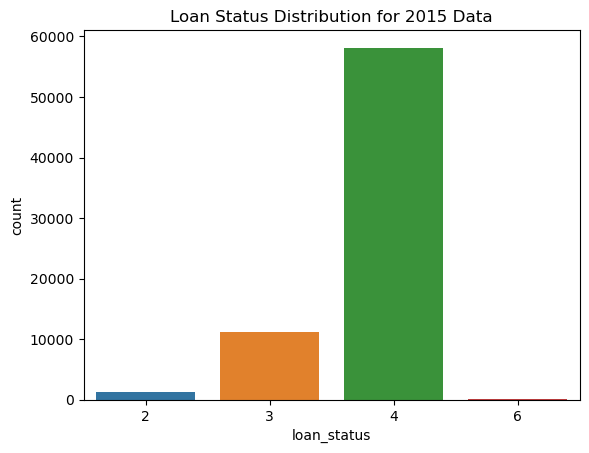

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Explore distributions of features and target variable
sns.countplot(x='loan_status', data=loans_2015)
plt.title('Loan Status Distribution for 2015 Data')
plt.show()





## Visualizations Contrived Analysis
#### These research questions are on the menu and will be explored in chronological fashion:
* Does income bracket placement affect loan condition qualities?
* Do certain occupations receive better loan conditions over others?
* What variables constitute a higher Prosper Score?

In [42]:
# Constructing a more chart friendly loans table
loan_chart_df = loans_2015[['term', 'amount_borrowed', 'borrower_apr', 'borrower_rate']].copy()
loan_chart_df = loan_chart_df.rename(columns={'amount_borrowed':'Amount', 'borrower_apr':'APR', 'borrower_rate':'Rate'})
loan_chart_df['Income'] = loans_2015['income_range'].copy()
loan_charts = pd.DataFrame(loan_chart_df)
print(loan_charts['Income'].value_counts())
loan_charts


Income
3    22920
4    21133
6    11556
5    11551
2     3633
Name: count, dtype: int64


,term,Amount,APR,Rate,Income
0,36,6000.0,0.10989,0.0819,3
1,36,3636.0,0.10989,0.0819,4
2,36,30000.0,0.13114,0.1028,6
3,36,15000.0,0.11446,0.0864,4
4,36,3500.0,0.17373,0.1373,3
...,...,...,...,...,...
70788,36,20000.0,0.07493,0.0613,6
70789,36,25000.0,0.18794,0.1512,4
70790,36,14901.0,0.08733,0.0736,3
70791,36,30000.0,0.11121,0.0832,6


#### Feature breakdown
Income is an ordinal qualitative. Term is ordinal quantitative. This influences chart designs. Due to its status as independent variable for the research question, charts will be categorized based on Income. Rate, APR, and Amount are continuous variables while Term is individually discrete, all dependent.
### Univariate Analysis
* What are population distributions of each feature?
* Which category or values of each chart contain the mode?
* Which meaningful insights can be concluded from these?

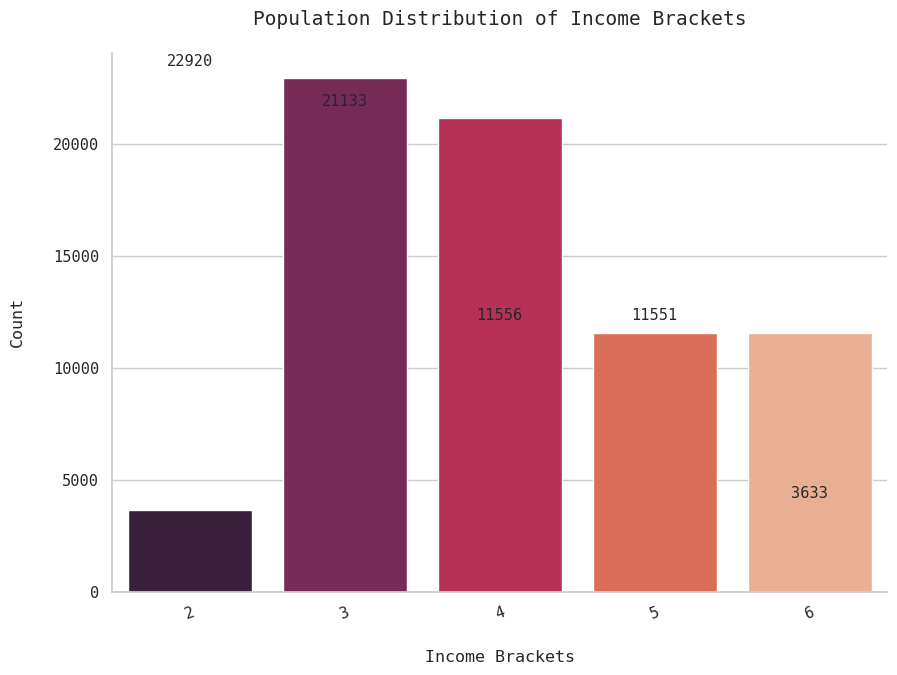

In [43]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'font.size': 11, 'axes.titlesize': 14,
                'axes.titlepad': 20}
sns.set(style='whitegrid', palette='rocket_r', font='monospace', rc=custom_params)
plt.figure(figsize=(10, 7))
sns.countplot(data=loan_charts, x='Income', palette='rocket')
plt.title('Population Distribution of Income Brackets')
plt.xticks(rotation=20)
plt.xlabel('Income Brackets', labelpad=20)
plt.ylabel('Count', labelpad=20)

# Printing values on bars
clarity_counts = loan_charts['Income'].value_counts(sort=False)
for i, count in enumerate(clarity_counts):
    plt.text(i, count + 1100, count, va='top', ha='center')


#### Income Brackets Insight
Income Bracket 3: This bracket contains 22,920 people.
Income Bracket 4: Here, we have 21,133 individuals.
Income Bracket 6: There are 11,556 people in this bracket.
Income Bracket 5: Similarly, 11,551 individuals fall into this category.
Income Bracket 2: The smallest group consists of 3,633 people.
In essence, this data reflects the distribution of population across different income levels. Prosper loans clearly has a customer base that is influenced by middle-income & higher-income loan conditions. Prosper needs to cater to this demand.

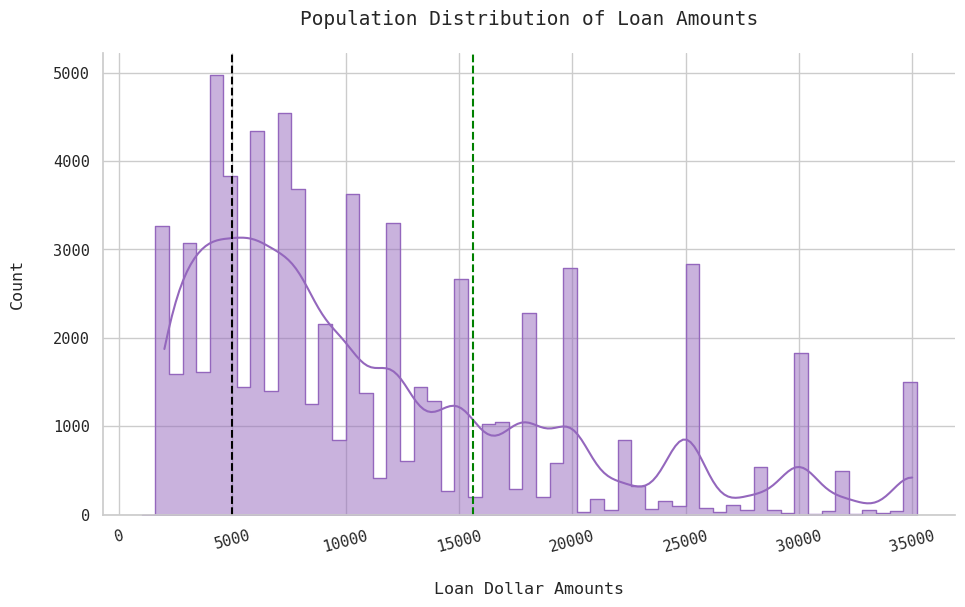

In [44]:
amount_bins = np.arange(1000, 35000+600, 600)
plt.figure(figsize=(11,6))
sns.histplot(data=loan_charts, x='Amount', color='tab:purple', bins=amount_bins, element='step', kde=True)
plt.title('Population Distribution of Loan Amounts')
plt.xticks(rotation=15)
plt.xlabel('Loan Dollar Amounts', labelpad=20)
plt.ylabel('Count', labelpad=20)

q1rt = np.quantile(loan_charts.Amount, .25)
plt.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(loan_charts.Amount, .75)
plt.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

#### Loan Amounts Insight
A bin selection with a step of .01 was chosen to split values on the hundredth decimal place instead of the thousandth. This encourages a more realistic breakdown of the chart as percents are hardly inspected to the thousandth. Past 25,000 loan amount counts steeply drop off. It must be difficult obtaining such a loan. Moreover, there are favorite amounts: 5000, 7500remain popular. Prosper should acknowledge this in their marketing campaign to bring in more customers. Focus on these amounts to push sales numbers.

C:\Users\saisu\AppData\Local\Temp\ipykernel_724\764162725.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)
C:\Users\saisu\AppData\Local\Temp\ipykernel_724\764162725.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax1.get_xticklabels(), rotation=15)


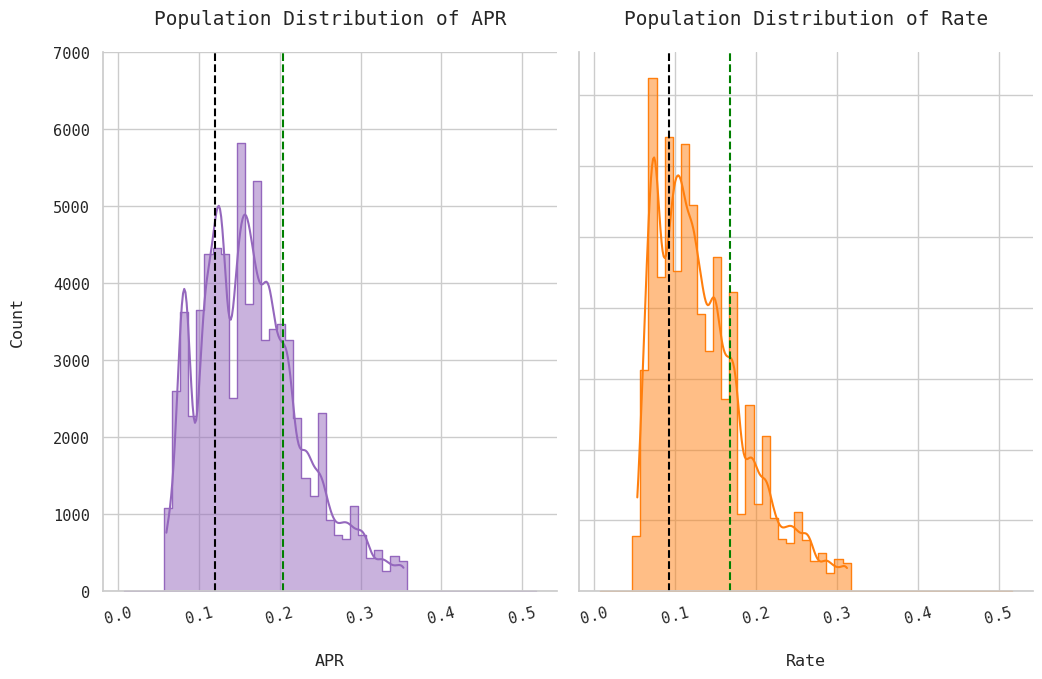

In [45]:
APR_bins = np.arange(.007, .512+.01, .01)
Rate_bins = np.arange(0, .497+.01, .01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Left chart
sns.histplot(data=loan_charts, x='APR', color='tab:purple', element='step', kde=True, bins=APR_bins, ax=ax1)
ax1.set_title('Population Distribution of APR')
ax1.set_xlabel('APR' , labelpad=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)
ax1.set_yticks(range(0, 7001, 1000))
ax1.set_ylabel('Count', labelpad=20)

q1rt = np.quantile(loan_charts.APR, .25)
ax1.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(loan_charts.APR, .75)
ax1.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

# Right chart
sns.histplot(data=loan_charts, x='Rate', color='tab:orange', element='step', kde=True, bins=APR_bins, ax=ax2)
ax2.set_title('Population Distribution of Rate')
ax2.set_xlabel('Rate', labelpad=20)
ax2.set(yticklabels=[])
ax2.set_ylabel('')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=15)
ax2.set_yticks(range(0, 7001, 1000))
q1rtR = np.quantile(loan_charts.Rate, .25)
ax2.axvline(x=q1rtR, label='Q1', c='black', linestyle='dashed')
q1rtR3 = np.quantile(loan_charts.Rate, .75)
ax2.axvline(x=q1rtR3, label='Q3', c='green', linestyle='dashed')

plt.subplots_adjust(wspace=.05)

#### APR Insight
Customer should expect to receive an APR .15 - .35. Most common APRs are .15-.2 & .3 & 3.6. For ideal insight, Prosper should plan financing assuming the average loan borrower will reveive an APR within this range. The further outside the range the more unlikely it becomes for that APR to be provided.
#### Rate Insight
Customer should expect to receive a rate .1 - .325. Most common rates are .125 & .325. For ideal insight, Prosper should plan financing assuming the average loan borrower will reveive a rate within this range. The further outside the range the more unlikely it becomes for that rate to be provided.

### Bivariate Analysis
* Do income brackets favor certain terms over others?
* What is the distribution of each feature per Income Bracket?
* Any noticable APR or Rate benefits when moving up the Income bracket ladder?

Text(0, 0.5, 'Count')

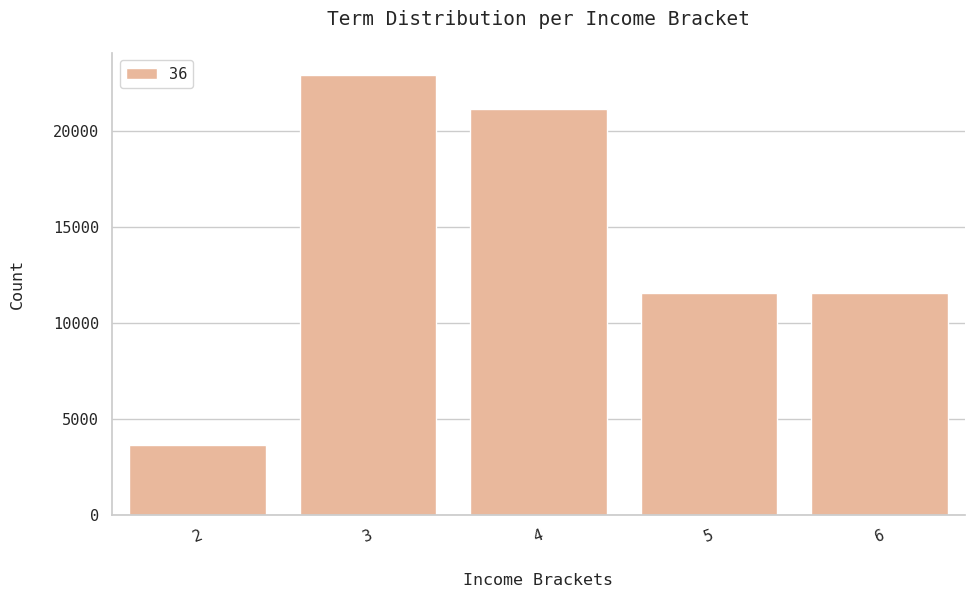

In [46]:
plt.figure(figsize=(11,6))
sns.countplot(data=loan_charts, x='Income', hue='term')
plt.title('Term Distribution per Income Bracket')
plt.xticks(rotation=20)
plt.xlabel('Income Brackets', labelpad=20)
plt.legend(loc='upper left')
plt.ylabel('Count', labelpad=20)

#### Term x Income Bracket Insight
No matter the income, 36 terms is the gold standard.

Text(0, 0.5, 'Loan Amount')

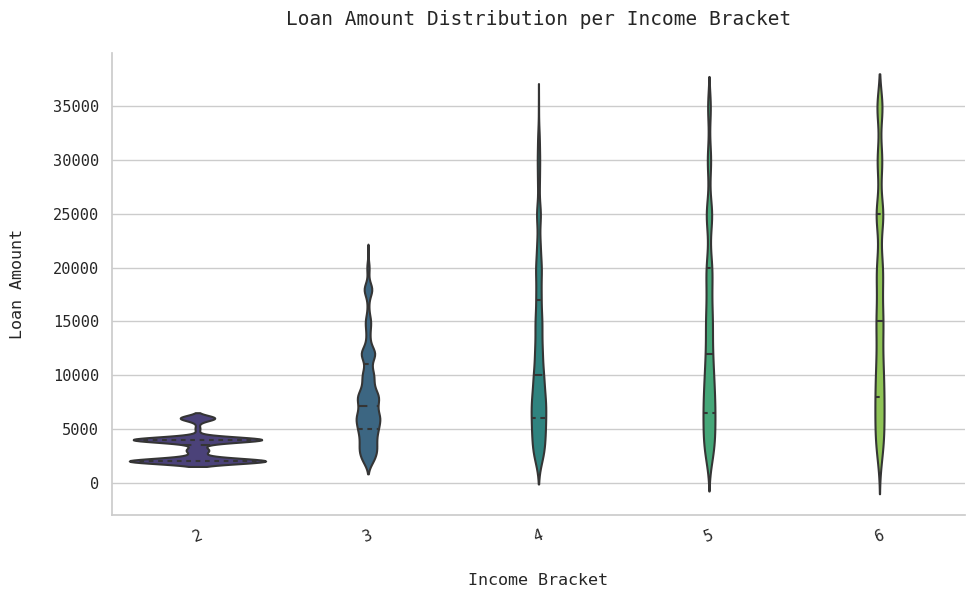

In [47]:
plt.figure(figsize=(11,6))
sns.violinplot(data=loan_charts, x='Income', y='Amount', inner='quartiles', palette='viridis')
plt.xticks(rotation=20)
plt.title('Loan Amount Distribution per Income Bracket')
plt.xlabel('Income Bracket', labelpad=20)
plt.ylabel('Loan Amount', labelpad=20)

#### Loan x Income Bracket Insight
The lowest bracket has a wider distribution range compared to the others. Surprisingly, loan amounts vary very little between categories. Prosper can keep this in mind as targeted loan amounts will receive little payout. Customers of varying incomes can choose either low or high.

Text(0, 0.5, 'APR')

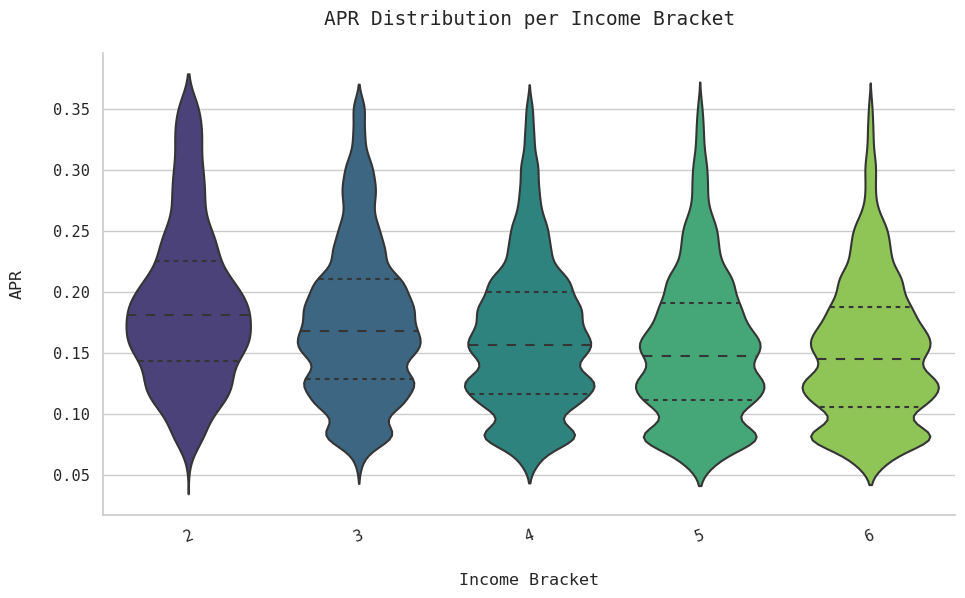

In [48]:
plt.figure(figsize=(11,6))
sns.violinplot(data=loan_charts, x='Income', y='APR', inner='quartiles', palette='viridis')
plt.xticks(rotation=20)
plt.title('APR Distribution per Income Bracket')
plt.xlabel('Income Bracket', labelpad=20)
plt.ylabel('APR', labelpad=20)

#### APR x Income Bracket Insight
Individuals in the highest tier should slighty more expect a higher APR due to their improved financial status. Slightly expected only due to the even distribution across categories. Prosper has better APR flexibilty when customers make more as shown through the 100,000 category.

Text(0, 0.5, 'Rate')

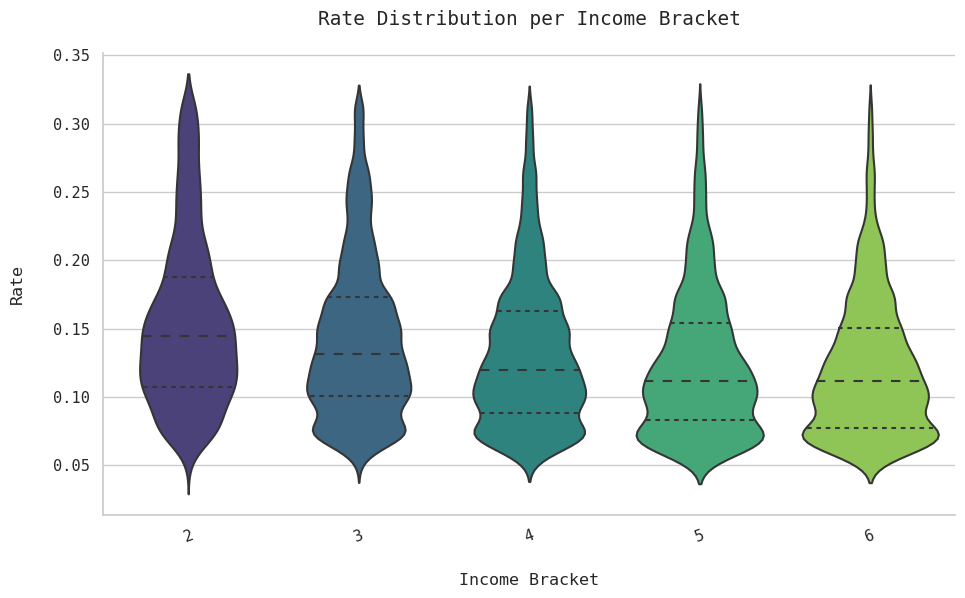

In [49]:
plt.figure(figsize=(11,6))
sns.violinplot(data=loan_charts, x='Income', y='Rate', inner='quartiles', palette='viridis')
plt.xticks(rotation=20)
plt.title('Rate Distribution per Income Bracket')
plt.xlabel('Income Bracket', labelpad=20)
plt.ylabel('Rate', labelpad=20)

#### Rate x Income Bracket Distribution Insight
Individuals in the highest tier should slighty more expect a higher rate due to their improved financial status. Slightly expected only due to the even distribution across categories. Prosper has better rate flexibilty when customers make more as shown through the 100,000 category. Inversly, 0 provides a reliable return of rates from lack of outliers. Like APR, 1-24,999 mimics 100,000 closer than the inbetween categories. Customers in the middle should worry less about receiving an extreme rate.
### Multivariate Analysis
* Are better APRs, rates or higher loan amounts associated to higher income?
* Are APRs & rates determined using similar metrics?
* Do heatmaps or scatterplots show these relationships more effectively?

C:\Users\saisu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


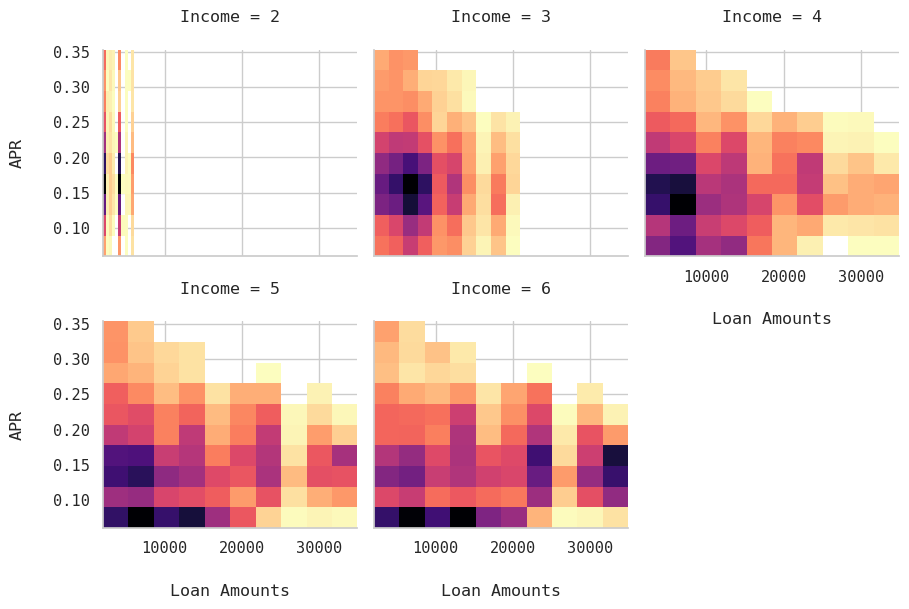

In [50]:
FG = sns.FacetGrid(data=loan_charts, col='Income', col_wrap=3, height=3)
FG.map(plt.hist2d, 'Amount', 'APR', cmap='magma_r', cmin=2, bins=10)
FG.set_xlabels('Loan Amounts', labelpad=20)
FG.set_ylabels('APR', labelpad=20)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

C:\Users\saisu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


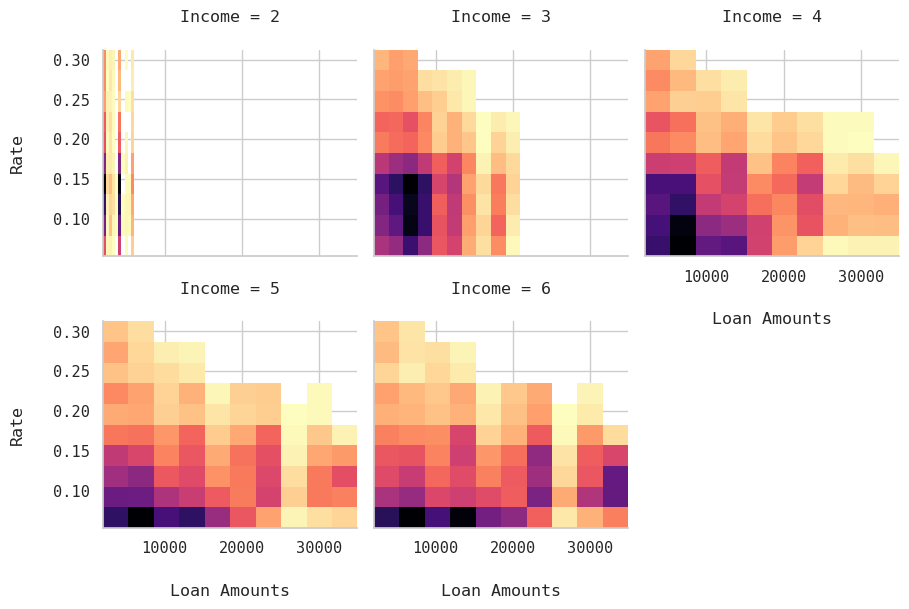

In [51]:
FG = sns.FacetGrid(data=loan_charts, col='Income', col_wrap=3, height=3)
FG.map(plt.hist2d, 'Amount', 'Rate', cmap='magma_r', cmin=2, bins=10)
FG.set_xlabels('Loan Amounts', labelpad=20)
FG.set_ylabels('Rate', labelpad=20)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

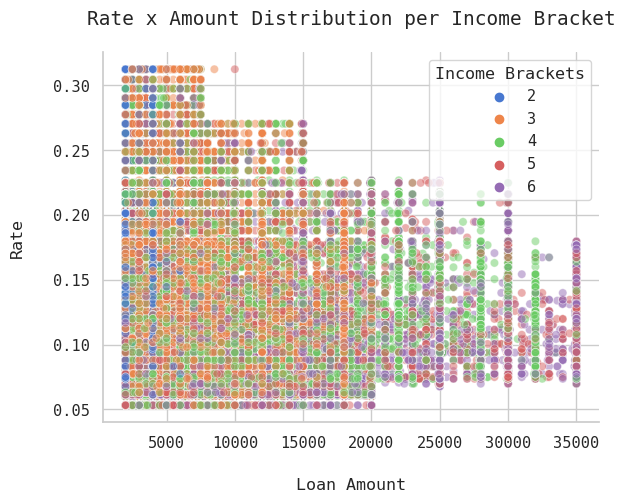

In [52]:
# Ordinal & income grouping lists
#inc_order = ['$0-24,999', '$25,000-74,999', '$75,000+']
#category_mapping_income = {
 #   '$0-24,999': ['$0', '$1-24,999'],
  #  '$25,000-74,999': ['$25,000-49,999', '$50,000-74,999'],
  #  '$75,000+': ['$75,000-99,999', '$100,000+']

marker_styles = {
    '2': 'o',
    '3': '^',
    '4': 'D',
    '5': 's',
    '6': 'p',
    # Add markers for missing levels
    # '7': 'X',
    # '8': 'h',
}

sns.scatterplot(data=loan_charts, x='Amount', y='Rate', hue='Income', alpha=0.5, markers=marker_styles,
               palette='muted')
plt.title('Rate x Amount Distribution per Income Bracket')
plt.xlabel('Loan Amount', labelpad=20)
plt.ylabel('Rate', labelpad=20)
plt.legend(title='Income Brackets')


#### Rate x Loan Amount per Income Bracket Insight
Chart readibility was at an all time low with 5 income brackets. Looked like a glob of rainbow goo. To rectify, income brackets were grouped into pairs of 3 instead of individual 6. This chart provides evidence for minimum & maximum loan amounts being accessible to any income bracket. On the contrary, distribution is mixed. 25,000-75000+ tiers are readily given loans of 25000+, where the lowest tier generally has access lower than 25,000. It also appears rate is not affixed to income bracket, given the wide and uniform distribution of each income bracket. Prosper needs to limit access of higher loans to 0-24,999 more. There shouldn't be any customer of that stature acquitted with a loan they can't pay back.

## *Research Question #2*
#### *Do certain occupations receive better loan conditions over others? Are term lengths evenly distributed?*

In [53]:
occ_charts = loans_2015[['term', 'amount_borrowed', 'borrower_apr', 'borrower_rate']].copy()
occ_charts = occ_charts.rename(columns={'amount_borrowed':'Loan Amount', 'borrower_apr':'APR', 'borrower_rate':'Rate'})
occ_charts['Occupation'] = loans_2015['occupation'].copy()
occ_charts

,term,Loan Amount,APR,Rate,Occupation
0,36,6000.0,0.10989,0.0819,Other
1,36,3636.0,0.10989,0.0819,Other
2,36,30000.0,0.13114,0.1028,Analyst
3,36,15000.0,0.11446,0.0864,Teacher
4,36,3500.0,0.17373,0.1373,Retail Management
...,...,...,...,...,...
70788,36,20000.0,0.07493,0.0613,Professional
70789,36,25000.0,0.18794,0.1512,Engineer - Electrical
70790,36,14901.0,0.08733,0.0736,Sales - Retail
70791,36,30000.0,0.11121,0.0832,Executive


In [54]:
occ_charts.Occupation.value_counts()

Occupation
Other                                     21935
Professional                               6926
Executive                                  2463
Clerical                                   2300
Teacher                                    2260
                                          ...  
Student - College Freshman                    8
Student - College Sophomore                   6
Student - Technical School                    5
Nurse - Licensed Practical Nurse (LPN)        2
Student - Graduate School                     1
Name: count, Length: 72, dtype: int64

#### Feature Engineering
Occupations will be grouped into relative categories to provide better insight on graphs and reduce clutter, given the wide array of occupations listed.

In [55]:
category_mapping = {
    'Management & Leadership': ['Executive', 'Retail Management', 'Food Service Management', 'Police Officer/Correction Officer',
                                  'Military Officer', 'Principal', 'Judge'],
    'Skilled Trades': ['Skilled Labor', 'Construction', 'Tradesman - Mechanic', 'Tradesman - Electrician', 'Tradesman - Carpenter', 'Tradesman - Plumber'],
    'Sales & Marketing': ['Sales - Retail', 'Sales - Commission', 'Realtor', 'Car Dealer'],
    'Hospitality & Service': ['Food Service', 'Waiter/Waitress', 'Flight Attendant', 'Bus Driver', 'Religious'],
    'Healthcare & Nursing': ['Nurse (RN)', 'Nurse (LPN)', 'Nurse\'s Aide', 'Pharmacist', 'Doctor', 'Dentist'],
    'Education': ['Teacher', 'Professor', 'Teacher\'s Aide', 'Student - College Senior', 'Student - College Graduate Student', 'Student - College Sophomore',
                  'Student - College Junior', 'Student - College Freshman', 'Student - Community College', 'Student - Technical School'],
    'Legal & Financial': ['Accountant/CPA', 'Attorney'],
    'Engineering & Tech': ['Computer Programmer', 'Engineer - Mechanical', 'Engineer - Electrical', 'Engineer - Chemical'],
    'Science': ['Scientist', 'Biologist', 'Chemist'],
    'Public Service': ['Fireman', 'Civil Service', 'Postal Service', 'Social Worker', 'Military'],
    'Office Workers': ['Clerical', 'Clergy', 'Analyst', 'Investor', 'Psychologist'],
    'Creative & Arts': ['Architect', 'Landscaping', 'Homemaker'],
    'Transportation & Logistics': ['Truck Driver', 'Pilot - Private/Commercial'],
    'Other': ['Other'],
    'Professional': ['Professional']
}
occ_charts['Occupation'] = occ_charts['Occupation'].map({occupation: category for category, occupations in category_mapping.items() for occupation in occupations})
print(occ_charts.shape)
occ_charts.Occupation.value_counts()

(70793, 5)


Occupation
Other                         21935
Professional                   6926
Management & Leadership        6523
Skilled Trades                 4678
Office Workers                 4621
Sales & Marketing              4183
Healthcare & Nursing           3450
Engineering & Tech             3060
Education                      2908
Legal & Financial              2209
Hospitality & Service          1761
Public Service                 1760
Transportation & Logistics     1669
Creative & Arts                 400
Science                         348
Name: count, dtype: int64

#### Feature breakdown
Term is ordinal quantitative. Ocucpation is nominal quantitative. Due to its status as independent variable for the research question, charts will be categorized based on Occupation. Rate, APR, and Amount are continuous variables while Term is individually discrete, all dependent.
### Univariate Analysis
* Population distributions for the qualitative features: Occupaton & Term
* Is there an outstanding difference between the mode category and the min category?
* Unimodal, bimodal or multimodal?

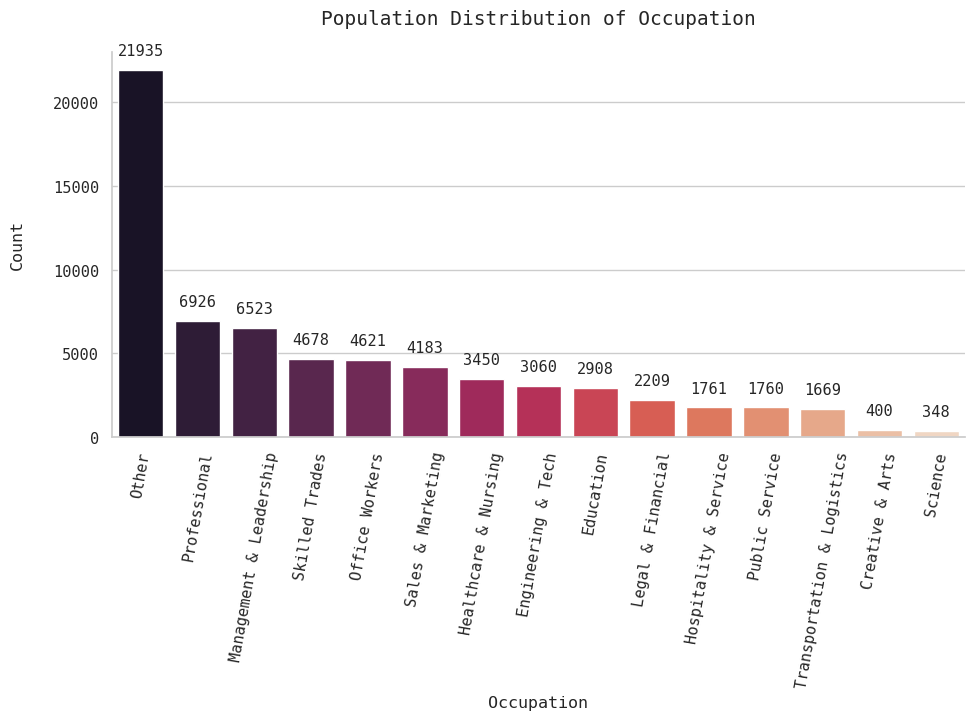

In [56]:
# Pre-chart setup

occ_charts['term'] = loan_charts['term']

popXocc = occ_charts.Occupation.value_counts().index
plt.figure(figsize=(11,5))
sns.countplot(data=occ_charts, x='Occupation', palette='rocket', order=popXocc)
plt.xticks(rotation=80)
plt.title('Population Distribution of Occupation')
plt.ylabel('Count', labelpad=20)

# Printing values on bars
clarity_counts = occ_charts['Occupation'].value_counts()
for i in range(clarity_counts.shape[0]):
    total = clarity_counts[i]
    plt.text(i, total+1600, total, va='top', ha='center')

#### Occupation Insight
Other is by far the mode, but this is presumably due to it's vast reach across the job sphere. Sadly the information behind what makes up Other is vacant. Diving deeper into that category would be insightful but I digress. Creative & Arts and Science are barely noticable in the back. Prosper could consider making marketing attempts to these groups for easy growth unless there's an absence of workers available. An alternative and proven effective approach is targeting Professional to Legal & Financial categories. Word spreads easily since employees are in close proximity, in other words free advertising.

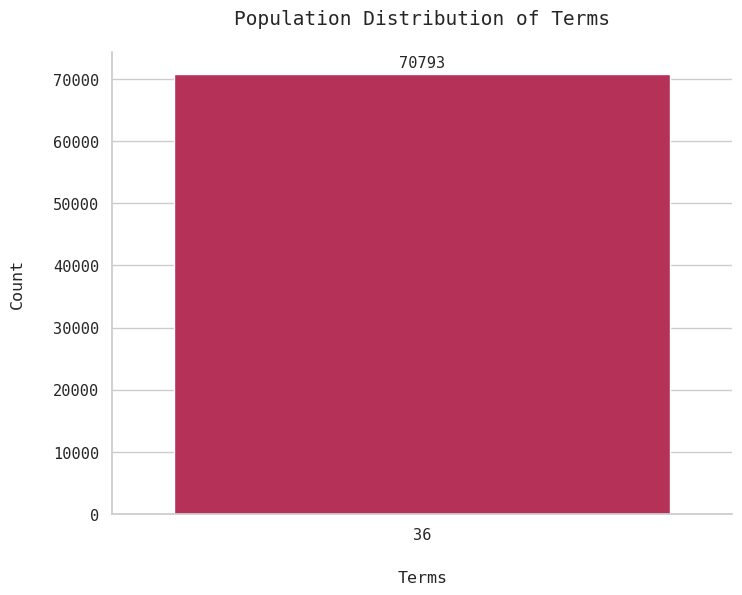

In [57]:
plt.figure(figsize=(8, 6))
sns.countplot(data=occ_charts, x='term', palette='rocket')
plt.title('Population Distribution of Terms')
plt.xlabel('Terms', labelpad=20)
plt.ylabel('Count', labelpad=20)

# Printing values on bars
clarity_counts = occ_charts['term'].value_counts(sort=False)
for i in range(clarity_counts.shape[0]):
    total = clarity_counts.iloc[i]
    plt.text(i, total+3000, total, va='top', ha='center')

### Bivariate Analysis
* Do certain professions land people in positions to take out higher amount loans?
* Are any categories able to pull in more people obtaining a specific loan amount compared to Other?
* Which occupations have the highest value outliers for loan amounts?

Text(0.5, 1.0, 'Loan Amount Distribution per Occupation')

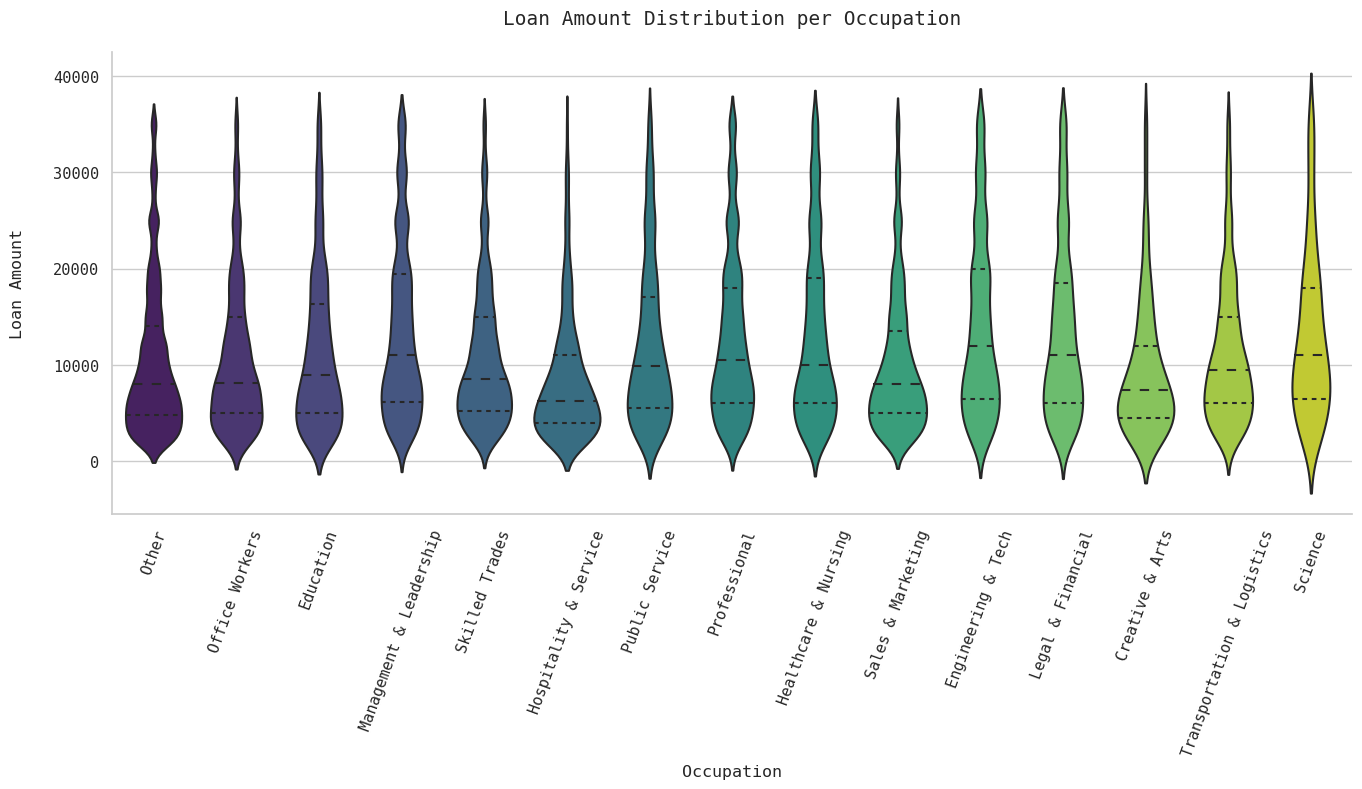

In [58]:
plt.figure(figsize=(16,6))
sns.violinplot(data=occ_charts, x='Occupation', y='Loan Amount', inner='quartiles', palette='viridis')
plt.xticks(rotation=70)
plt.ylabel('Loan Amount', labelpad=20)
plt.title('Loan Amount Distribution per Occupation')

#### Loan Amount x Occupation Insight
Due to their limited population or restricted financing, Creative & Arts has the strictest range for loan amounts available. Science  have the highest loan amounts recorded. Prosper can pursue this and secure higher loans within these occupations. Quartile ranges are similar showing how loan amounts or minimally correlated occupations. Other variables will likely be heavier influences, such as credit status. However, with the bottom quartile having such volume in all categories, Prosper needs to explore ways into enticing these lower loan amount borrowers into higher loans. If such an advertising strategy succeeds, profits will rise.
### Multivariate Analysis
* Does APR/rate and loan fluctuate between Occupations?
* Does Term lengths get a bonus of lower APR/rates?
* Are any terms able to secure higher loans?

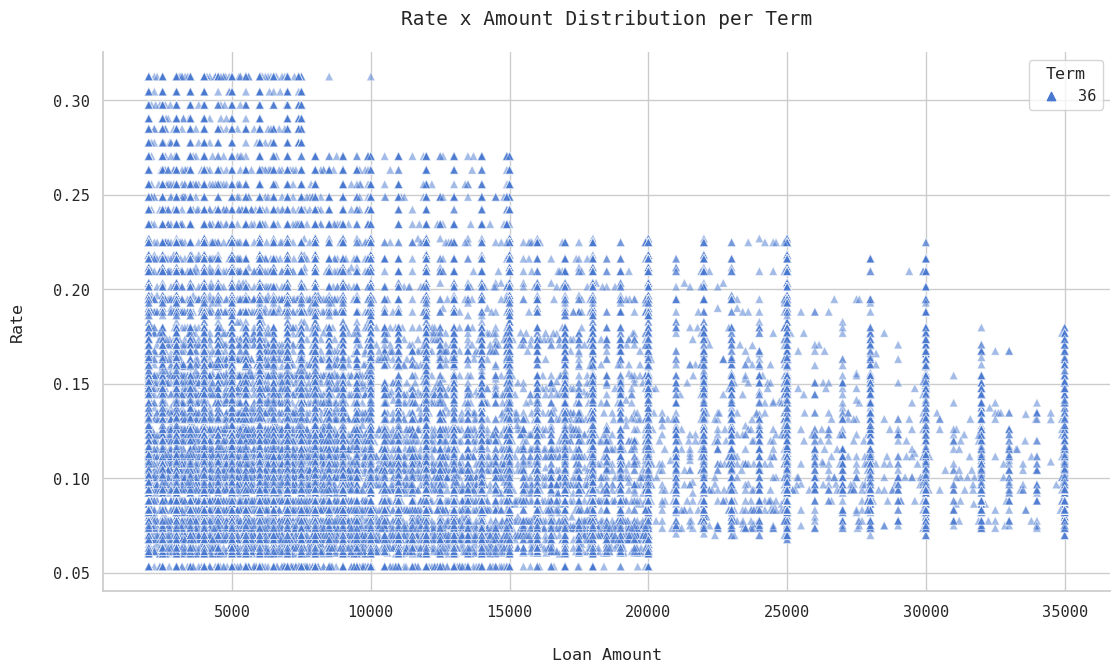

In [59]:
plt.figure(figsize=(13, 7))
marker_styles = {

    36: '^'
}
sns.scatterplot(data=loan_charts, x='Amount', y='Rate', hue='term', style='term', alpha=0.5, markers=marker_styles,
               palette='muted')
plt.title('Rate x Amount Distribution per Term')
plt.xlabel('Loan Amount', labelpad=20)
plt.ylabel('Rate', labelpad=20)
plt.legend(title='Term')
plt.show()

C:\Users\saisu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


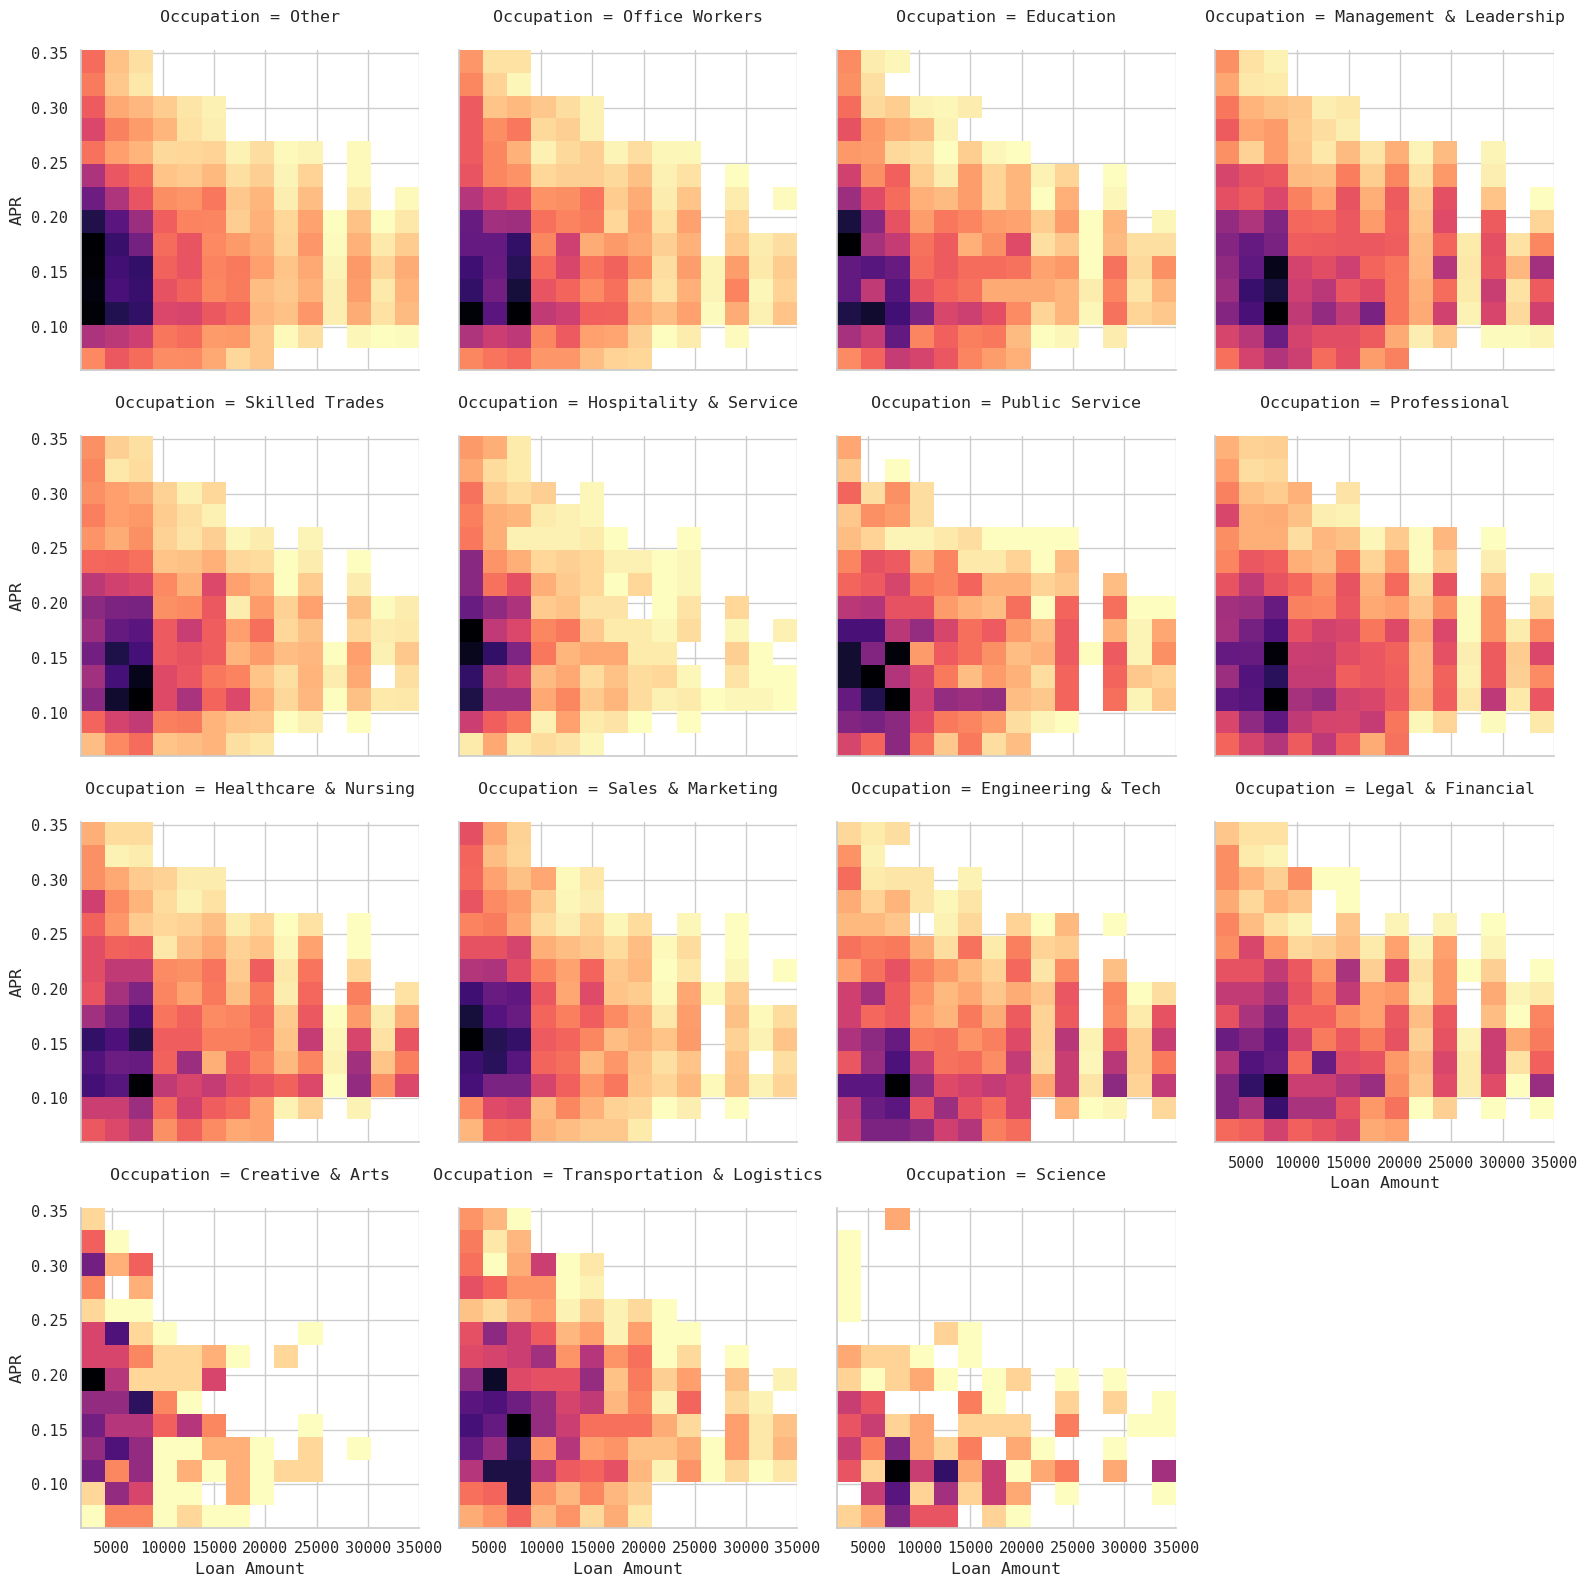

In [60]:
FG = sns.FacetGrid(data=occ_charts, col='Occupation', col_wrap=4, height=4)
FG.map(plt.hist2d, 'Loan Amount', 'APR', cmap='magma_r', cmin=2, bins=14)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

#### Loan Amount x APR per Occupation Insight
Healthcare & Nursing, Office Workers, Other, Sales & Marketing, Management & Leadership have similar distributions for .15 - .35 APR. These color density findings are probably related to their population counts. The similarities span across all occupations in regards to the most common APR and loan of .35 | 5,000. Generally APRs of around .3 are provided for lower amounts. Higher amounts such as 10,000+ receive a beneficial APR drop to around .2; with 25,000+ hovering around .15. Prosper is doing a swell job staying competitive with rates for the bigger loans as shown by the white cells in the top right corner of each subplot.

C:\Users\saisu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


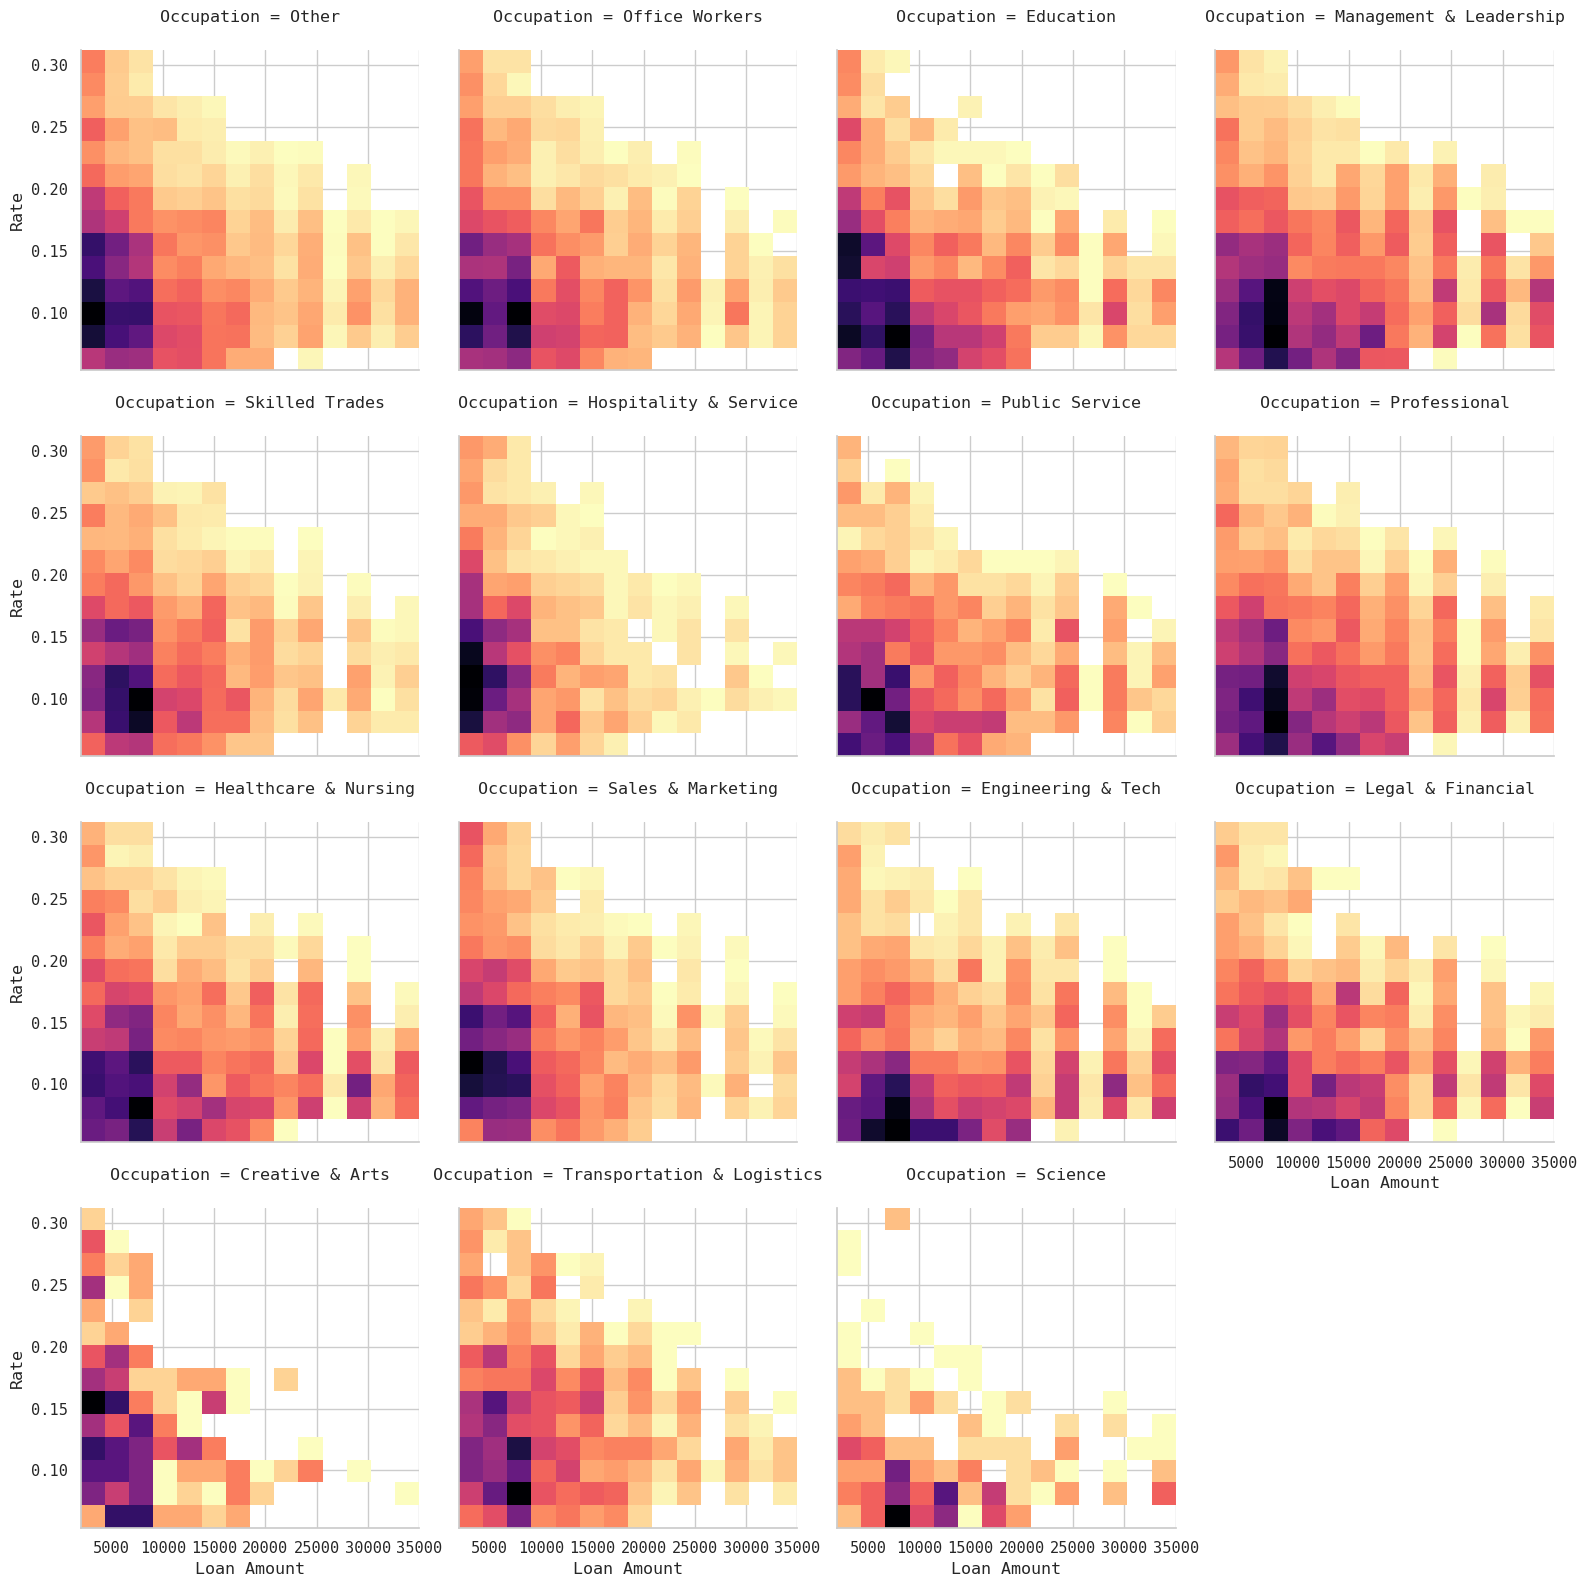

In [61]:
FG = sns.FacetGrid(data=occ_charts, col='Occupation', col_wrap=4, height=4)
FG.map(plt.hist2d, 'Loan Amount', 'Rate', cmap='magma_r', cmin=2, bins=14)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")

#### Loan Amount x Rate per Occupation Insight
Healthcare & Nursing, Office Workers, Other, Sales & Marketing, Management & Leadership have similar distributions for .15 - .35 APR. Office Workers have common Rates among it's customers considering it bimodial, almost multimodial status. Includes 8 darker colored cells. Skilled Trades also has a bimodial setup with 6 darker cells. Rates for these 2 categories be more shared compared to other categories. The similarities span across all occupations in regards to the most common rate and loan of .35 | 5,000. Generally rates of around .3 are provided for lower amounts. Higher amounts such as 10,000+ receive a beneficial rate drop to around .2; with 25,000+ hovering around .15. Prosper is doing a swell job staying competitive with rates for the bigger loans as shown by the white cells in the top right corner of each subplot.

## *Research Question #3*
#### *Are there variables that constitute a higher Prosper Score?*

In [62]:
score_charts = loans_2015[['prosper_score', 'income_verifiable', 'total_trade_items']].copy()
score_charts[['open_credit_lines',
              'current_delinquencies', 'amount_delinquent', 'prosper_rating']] = loans_2015[['open_credit_lines', 'current_delinquencies',
                                                                                    'amount_delinquent', 'prosper_rating']].copy()



# 1.0 is Yes, 0 is No
print(score_charts.income_verifiable.value_counts())
score_charts.head(5)

# Ordering ProsperScore
scores_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
PS_order = pd.CategoricalDtype(ordered=True, categories=scores_list)
score_charts['ProsperScore'] = score_charts['prosper_score'].astype(PS_order)

income_verifiable
True     68563
False     2230
Name: count, dtype: int64


In [63]:
score_charts.loc[score_charts['income_verifiable'] == True, 'income_verifiable'] = "Yes"
score_charts.loc[score_charts['income_verifiable'] == False, 'income_verifiable'] = "No"
print(score_charts.income_verifiable.value_counts())


income_verifiable
Yes    68563
No      2230
Name: count, dtype: int64


### Univariate Analysis
* Which ProsperScores are easist & hardest to obtain? Which type of mode?
* Is IncomeVerifiable a "Yes" value for majority of customers?
* How many open credit lines are average? What are the max range outliers?

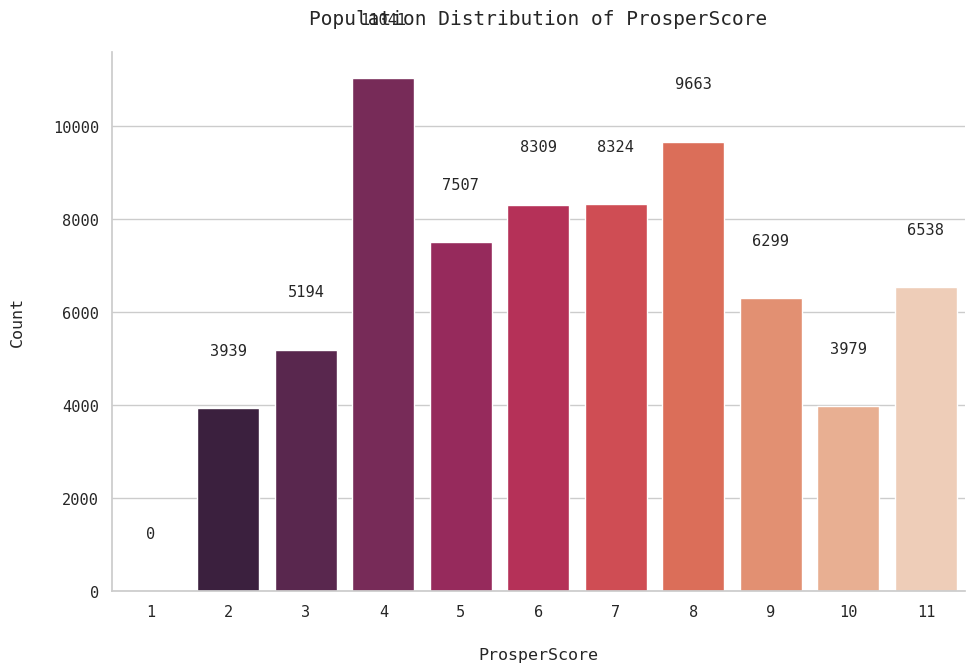

In [64]:
plt.figure(figsize=(11,7))
sns.countplot(data=score_charts, x='ProsperScore', palette='rocket')
plt.title('Population Distribution of ProsperScore')
plt.ylabel('Count', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

# Printing values on bars
clarity_counts = score_charts['ProsperScore'].value_counts(sort=False)
for i in range(clarity_counts.shape[0]):
    total = clarity_counts.iloc[i]
    plt.text(i, total+1400, total, va='top', ha='center')

#### ProsperScore Insight
The middle tiers of 4, 6, and 8 contain most records. Leading by 6 due to the mean impute that was enacted on null values. It's equally difficult to achieve a high ProsperScore and a low. Customers should aim for a 6 or above to be considered average or above average.

In [65]:
from matplotlib.font_manager import FontProperties

Text(0.5, 1.0, 'Income Verifiable Distribution')

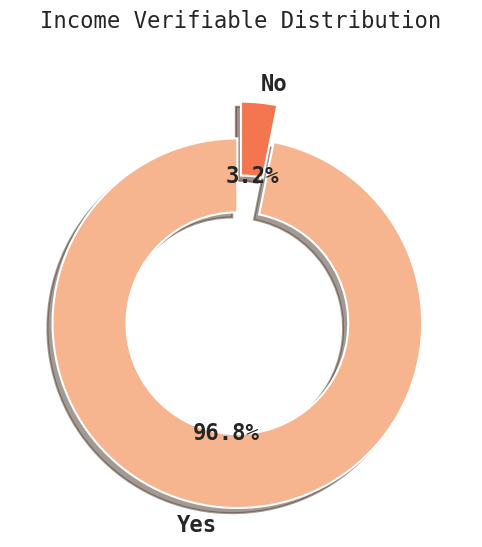

In [66]:
labels = ['Yes', 'No']
sizes = [68563, 2230]
explode = (0.2, 0)
bold_font = FontProperties(weight='bold', size=16)
plt.figure(figsize=(10,6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90,
       wedgeprops={'width':.4, 'linewidth':1.5}, textprops={'fontproperties': bold_font})
plt.title('Income Verifiable Distribution', size=16)

#### Income Verifiable Insight
Loans are easier to obtain when financial status is verified. This enables Prosper to deal offers or loan conditions in confidence. Efforts by both parties should be done to reduce the "No" 3.2% figure.

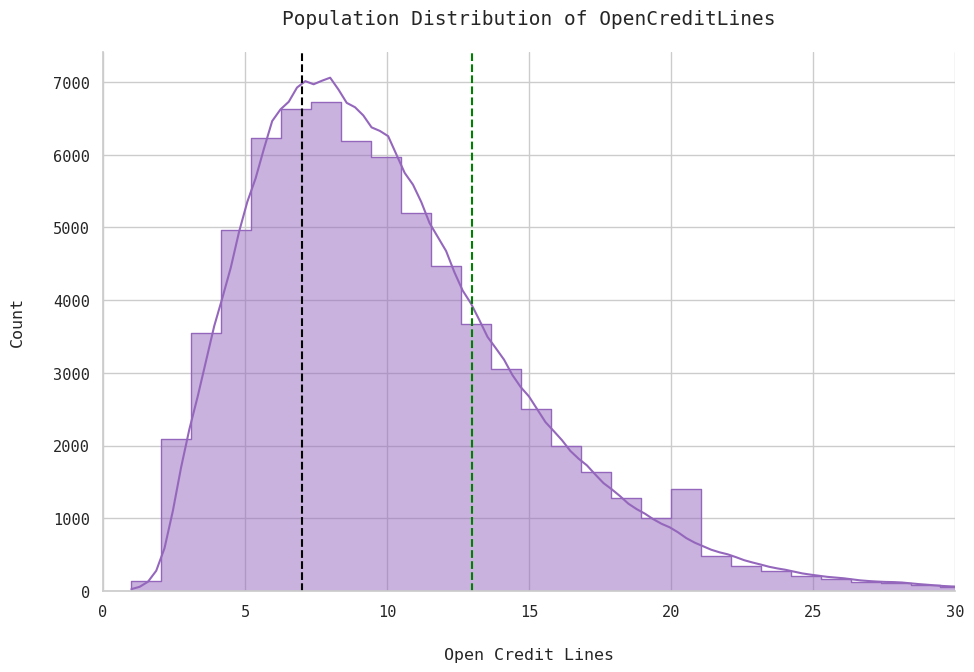

In [67]:
plt.figure(figsize=(11,7))
sns.histplot(data=score_charts, x='open_credit_lines', color='tab:purple', element='step', kde=True, bins=55)
plt.title('Population Distribution of OpenCreditLines')
plt.xlabel('Open Credit Lines', labelpad=20)
plt.ylabel('Count', labelpad=20)
plt.xlim(0, 30)

q1rt = np.quantile(score_charts.open_credit_lines, .25)
plt.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(score_charts.open_credit_lines, .75)
plt.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

#### Open Credit Lines Insight
Mode is 10. There is a steeper rise compared to the fall indicating larger increases for each value in 1-10 compared to 10+. Abundant credit lines are rarer to see, such as 20.

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U2'), dtype('<U2')) -> None

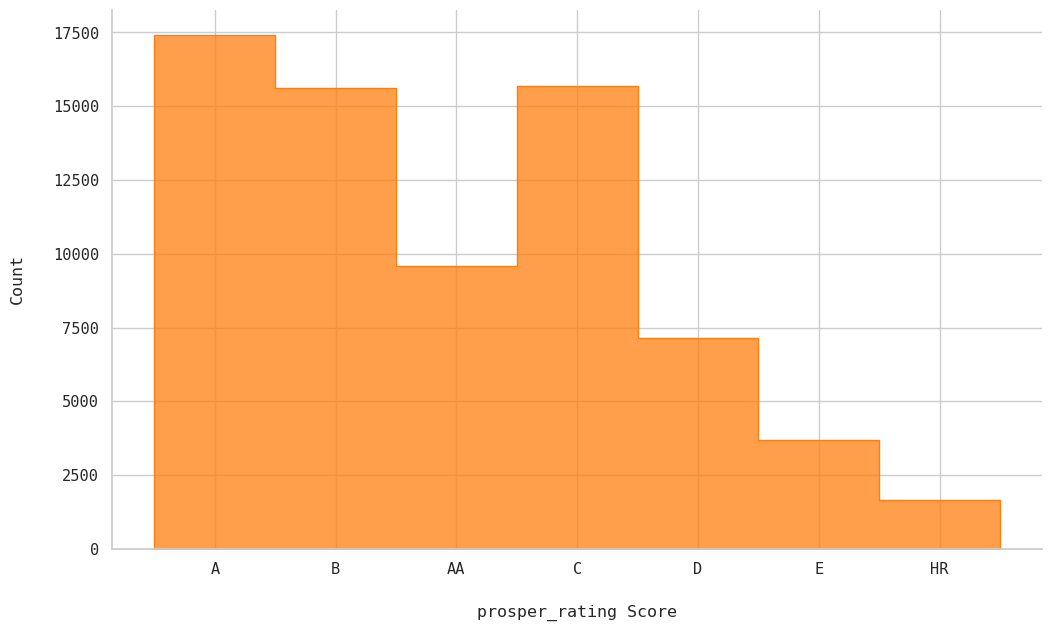

In [68]:
plt.figure(figsize=(12, 7))
sns.histplot(data=score_charts, x='prosper_rating', bins=46, color='tab:orange', element='step')
plt.xlabel('prosper_rating Score', labelpad=20)
plt.ylabel('Count', labelpad=20)
q1rt = np.quantile(score_charts['prosper_rating'], .25)
plt.axvline(x=q1rt, label='Q1', c='black', linestyle='dashed')
q1rt3 = np.quantile(score_charts['prosper_rating'], .75)
plt.axvline(x=q1rt3, label='Q3', c='green', linestyle='dashed')

plt.legend()
plt.show()

### Bivariate Analysis
* Which ProsperScore has the closest No:Yes IncomeVerifiable ratio?
* Do higher amount delinquent and current delinquencies correlate to lower ProsperScores?
* Are open credit lines or total trades show positive correlation to ProsperScores?

Text(0.5, 0, 'ProsperScore')

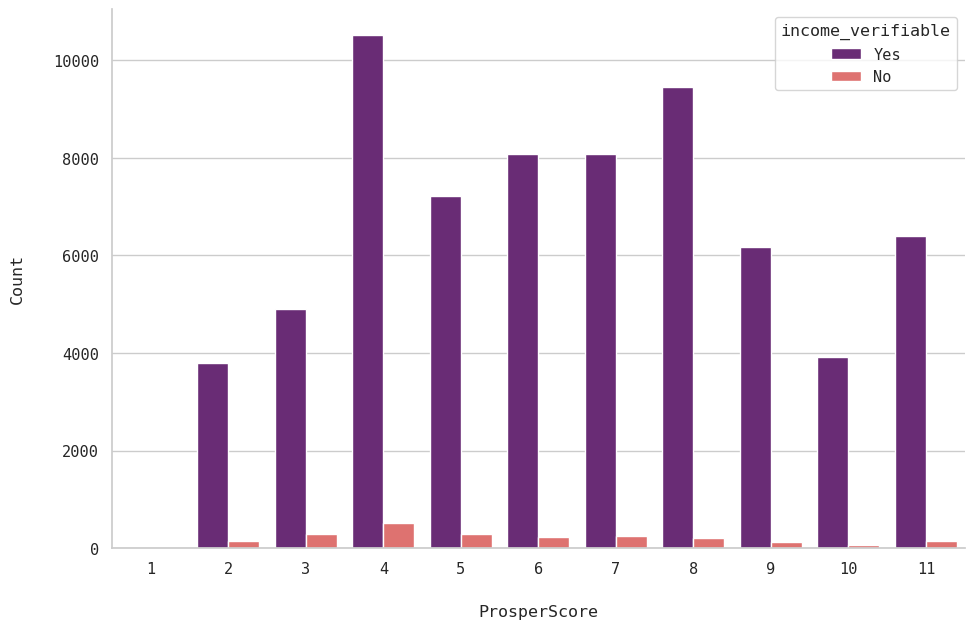

In [69]:
plt.figure(figsize=(11,7))
sns.countplot(data=score_charts, x='ProsperScore', hue='income_verifiable', palette='magma')
plt.ylabel('Count', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

#### ProsperScore x IncomeVerifiable Insight
Higher ProsperScores on tend to have proportionally less "No" values on IncomeVerifiable. ProsperScore 1 value has closest Yes:No ratio. This confirms that proving Income will help in obtaining a better ProsperScore, and are therefor one step closer to improved loan conditions.

Text(0.5, 0, 'ProsperScore')

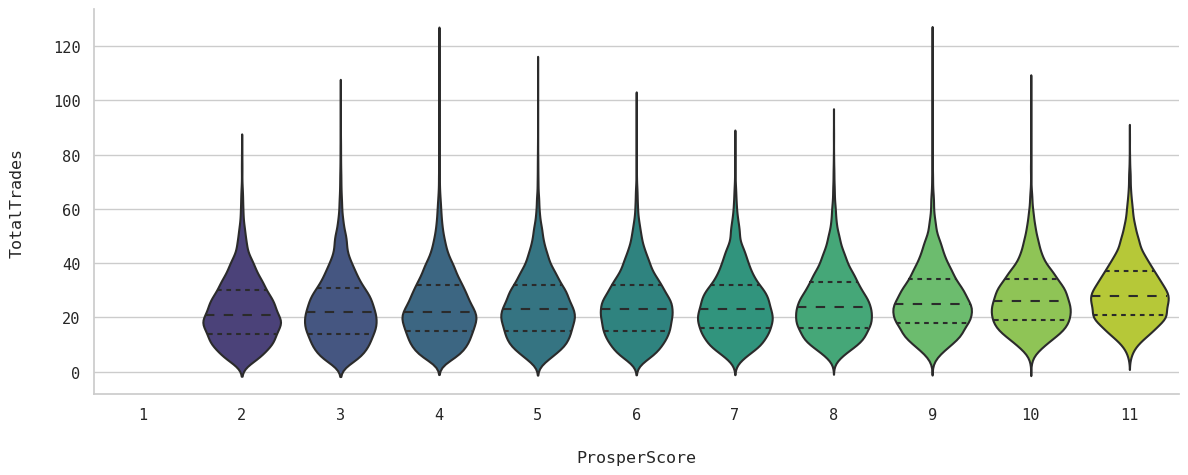

In [70]:
plt.figure(figsize=(14,5))
sns.violinplot(data=score_charts, x='ProsperScore', y='total_trade_items', inner='quartiles', palette='viridis')
plt.ylabel('TotalTrades', labelpad=20)
plt.xlabel("ProsperScore", labelpad=20)

Text(0.5, 0, 'ProsperScore')

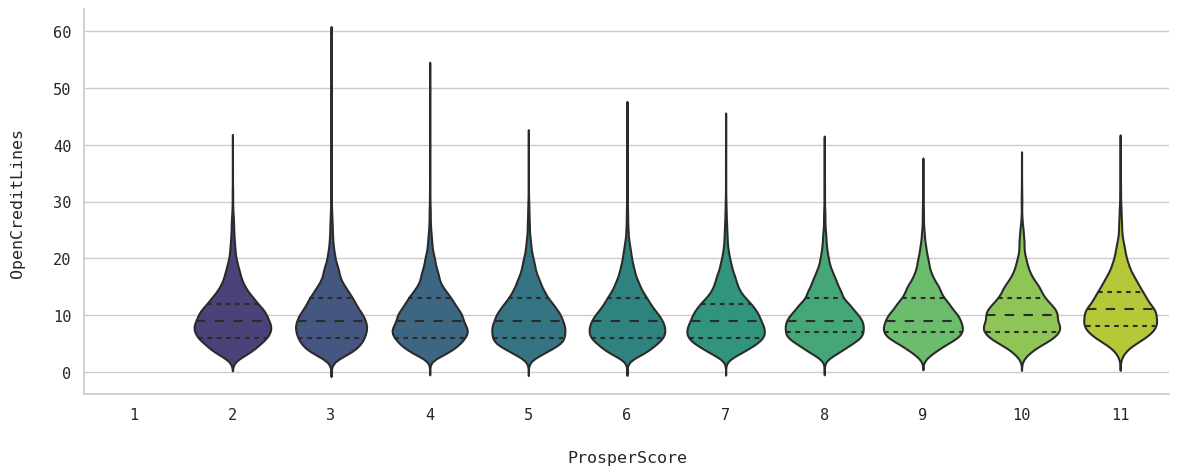

In [71]:
plt.figure(figsize=(14,5))
sns.violinplot(data=score_charts, x='ProsperScore', y='open_credit_lines', inner='quartiles', palette='viridis')
plt.ylabel('OpenCreditLines', labelpad=20)
plt.xlabel("ProsperScore", labelpad=20)

#### ProsperScore x OpenCreditLines Insight
Distributions are almost identical between ProserScores. Only significant difference in this chart are the outliers. These 2 features can be concluded as having no correlation.

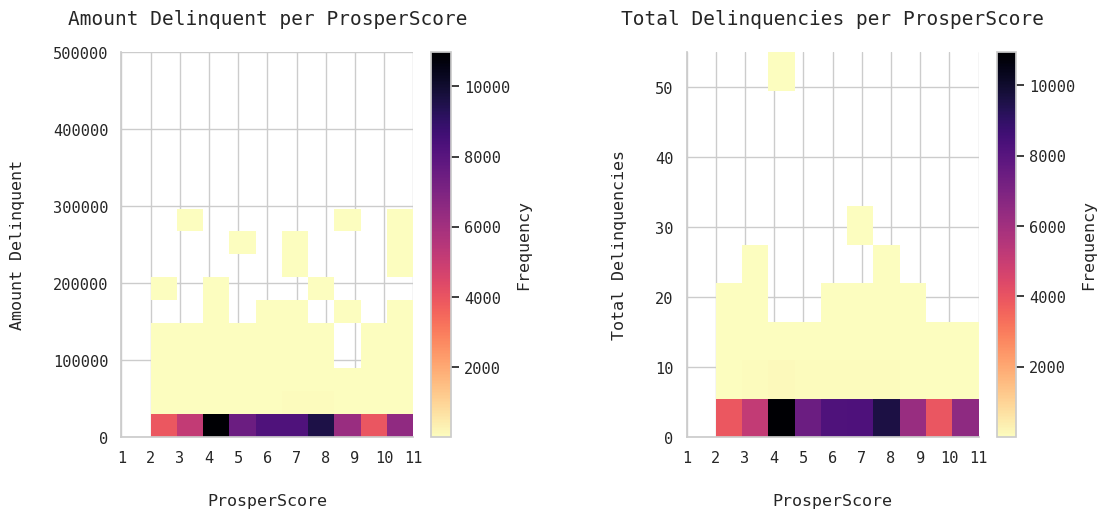

In [72]:
# Left chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
h1 = ax1.hist2d(data=score_charts, x='ProsperScore', y='amount_delinquent', cmap='magma_r', cmin=1, bins=10)
ax1.set_title('Amount Delinquent per ProsperScore')
ax1.set_xlabel('ProsperScore', labelpad=20)
ax1.set_ylabel('Amount Delinquent', labelpad=20)
ax1.set_xticks([item for item in range(1, 12)])
ax1.set_ylim(0, 500000)
cbar1 = plt.colorbar(h1[3], ax=ax1)
cbar1.set_label('Frequency')


# Right chart
h2 = ax2.hist2d(data=score_charts, x='ProsperScore', y='current_delinquencies', cmap='magma_r', cmin=1, bins=10)
ax2.set_title('Total Delinquencies per ProsperScore')
ax2.set_xlabel('ProsperScore', labelpad=20)
ax2.set_ylabel('Total Delinquencies', labelpad=20)
ax2.set_xticks([item for item in range(1, 12)])
cbar2 = plt.colorbar(h2[3], ax=ax2)
cbar2.set_label('Frequency')

plt.subplots_adjust(wspace=.55)

#### Amount Delinquent x ProsperScore & Total Delinquencies x Prosper Score Insight
The left heatmap provides insight into the fact of nearly all customers maintaining a delinquent balance equal to or lower than 50,000. Outliers do exist above this figure. The middle ProsperScores of 4-8 have a higher population of customers with a 50,000 or less delinquent balance compared to others. Mode is ProsperScore 6 @ 50,000, max is ~450,000. The right heatmap shows similar distribution. The bottom tier, or 10, is applicable instead of 50,000. Mode is ProsperScore 6 @ 10, max is ~80. Similar amount of outliers for both heatmaps.
### Multivariate Analysis
* Are open credit lines and total trades proportiniate to each other for each ProsperScore?
* Which ProsperScores have the most concentrated values for open credit lines and total trades?
* Are "No" IncomeVerifiable values often delinquent or have higher delinquent balances than "Yes" values?

C:\Users\saisu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


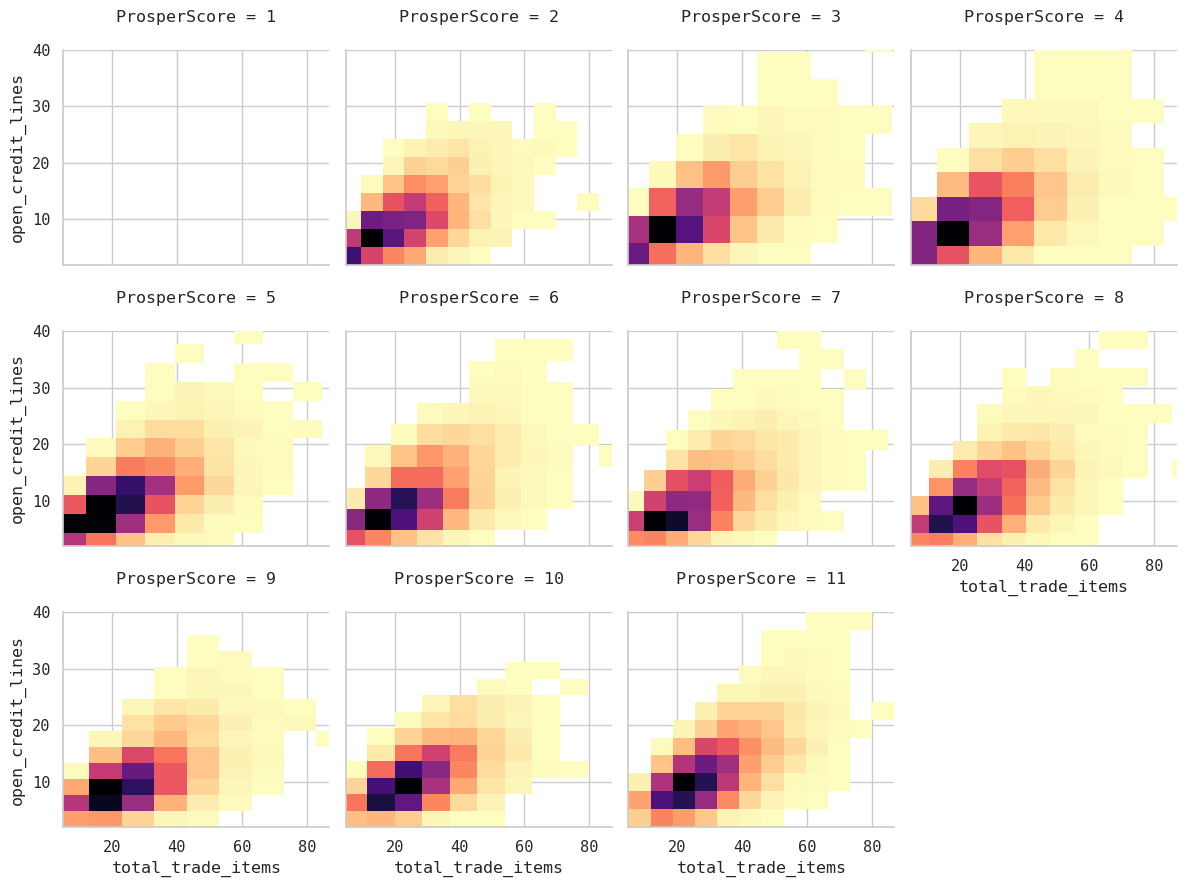

In [73]:
FG = sns.FacetGrid(data=score_charts, col='ProsperScore', col_wrap=4, height=3)
FG.map(plt.hist2d, 'total_trade_items', 'open_credit_lines', cmap='magma_r', cmin=2, bins=12)
for ax in FG.axes.flat:
    for c in ax.collections:
        c.set_edgecolor("none")



#### Total Trades x Open Credit Lines per ProsperScore Insight
Mode within all charts includes 20 Trades x 10 Credit lines. ProsperScores: 1, 2, 4, 6, 9, 11 have a split mode between 2 cells. Distribution for each ProsperScore, besides 6, has a radius of 2 cells where values gradually fade into lower amounts then dispersing into a large radius low yellow values. Customers who stick within the higher frequency radius will yield better loan conditions. Opening too many credit lines or trades is going against the status quo and could harm financial standing, according to Prosper and other loan providers. ProsperScore 4 & 6 have the least variance in values, contrasted by scores 10 & 11.

Text(0.5, 0, 'ProsperScore')

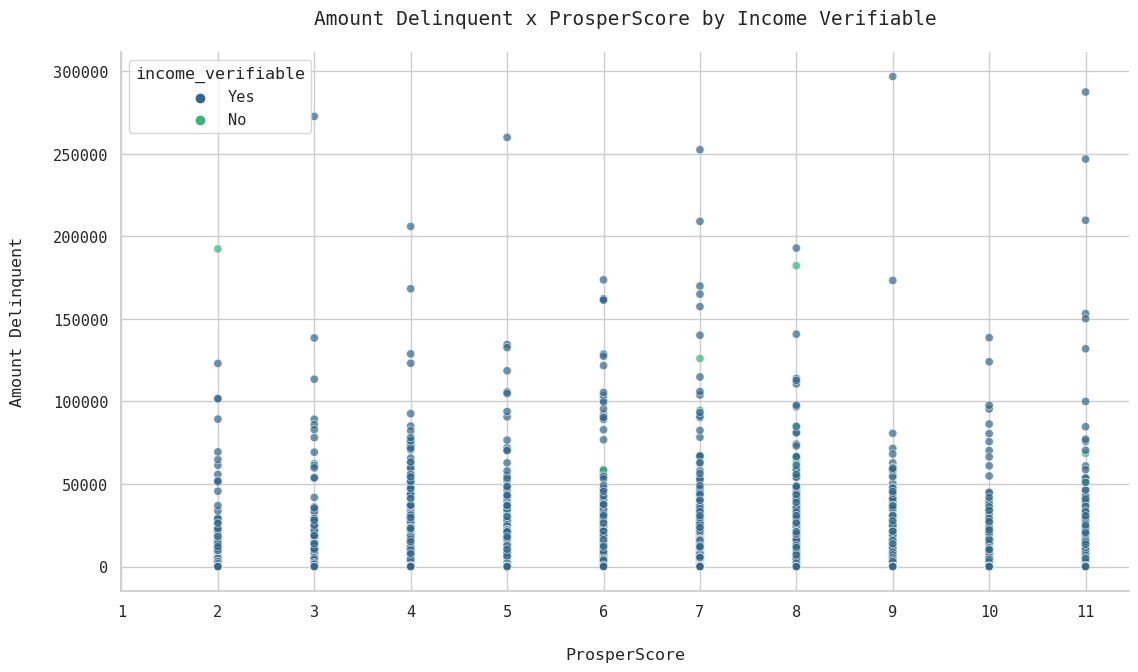

In [74]:
plt.figure(figsize=(13,7))
sns.scatterplot(data=score_charts, x='ProsperScore', y='amount_delinquent', palette='viridis', hue='income_verifiable',
               alpha=0.7)
plt.xticks([i for i in range(1,12)])
plt.title('Amount Delinquent x ProsperScore by Income Verifiable')
plt.ylabel('Amount Delinquent', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

Text(0.5, 0, 'ProsperScore')

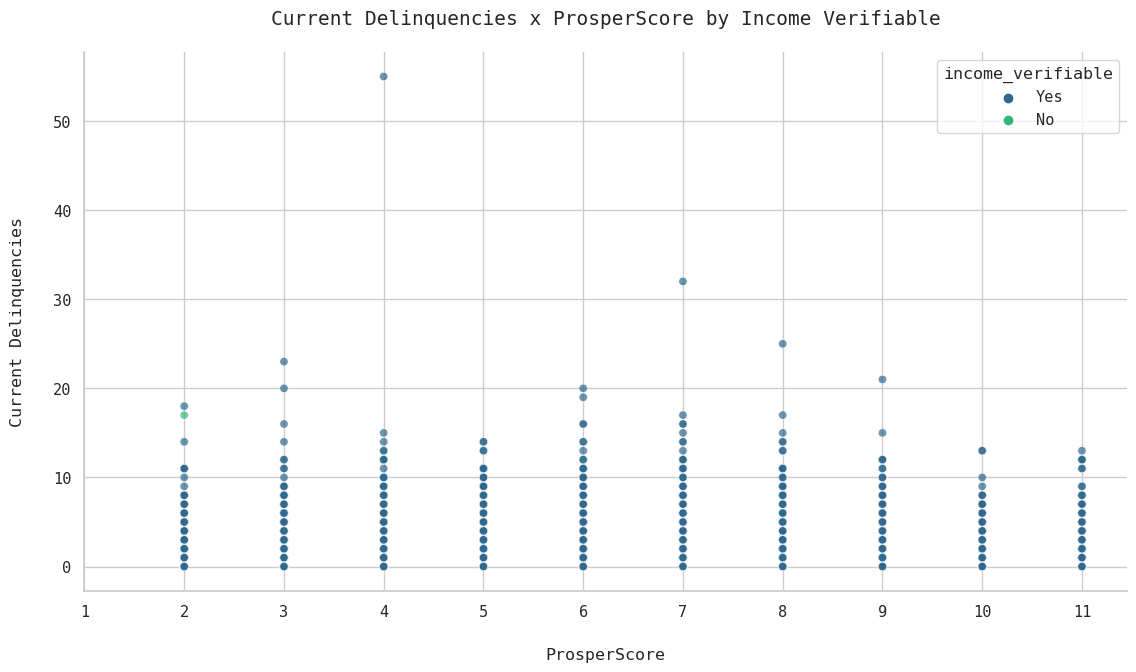

In [75]:
plt.figure(figsize=(13.45,7))
sns.scatterplot(data=score_charts, x='ProsperScore', y='current_delinquencies', palette='viridis', hue='income_verifiable',
               alpha=0.7)
plt.xticks([i for i in range(1,12)])
plt.title('Current Delinquencies x ProsperScore by Income Verifiable')
plt.ylabel('Current Delinquencies', labelpad=20)
plt.xlabel('ProsperScore', labelpad=20)

#### ProsperScore x CurrentDelinquents & ProsperScore x AmountDelinquent - by IncomeVerifiable Insight
"No" IncomeVarifiable values are prominently less common in categories 6+ in the bottom chart, and evenly dispersed in the top chart. ProsperScores 6, 7, 8, 10, 11 have scarce amounts or none of this value. Bottom chart outliers are equally dispersed between IncomeVerifiable, with the top chart dominated by "Yes" for this metric. Its possible Prosper does consider current delinquencies as more problematic than delinquent amount balance. It's advisable for customers to keep their current delinquencies in check. Having customers so embedded with debt such as 60+ current delinquences or 300,000 balance owed is a financial gamble. The safe play is to deny loan borrowers of this stature any new loans.

In [76]:
# Encode categorical variables
def label_encode(df):
    label_encoder = LabelEncoder()
    for col in df.select_dtypes(include=['object','bool']):
        df[col] = label_encoder.fit_transform(df[col])
    return df

loans_2015 = label_encode(loans_2015)
loans_2016 = label_encode(loans_2016)

In [77]:
loans_2015.head()

,prosper_rating,term,loan_status,borrower_apr,borrower_rate,prosper_score,occupation,employment_status_description,months_employed,open_credit_lines,...,total_inquiries,current_delinquencies,amount_delinquent,bankcard_utilization,total_trade_items,income_range,income_verifiable,loan_number,amount_borrowed,listing_monthly_payment
0,0,36,4,0.10989,0.0819,5.0,37,4,50.0,7.0,...,3.0,0.0,0.0,0.62,28.0,3,1,254360,6000.0,188.54
1,0,36,4,0.10989,0.0819,9.0,37,0,82.0,8.0,...,6.0,1.0,0.0,0.52,14.0,4,1,254372,3636.0,114.26
2,0,36,4,0.13114,0.1028,9.0,2,0,11.0,12.0,...,5.0,0.0,0.0,0.25,16.0,6,1,254399,30000.0,971.96
3,0,36,3,0.11446,0.0864,8.0,64,0,16.0,14.0,...,4.0,0.0,0.0,0.22,24.0,4,1,254402,15000.0,474.49
4,2,36,4,0.17373,0.1373,5.0,49,0,33.0,32.0,...,5.0,2.0,275.0,0.07,61.0,3,1,254414,3500.0,119.16


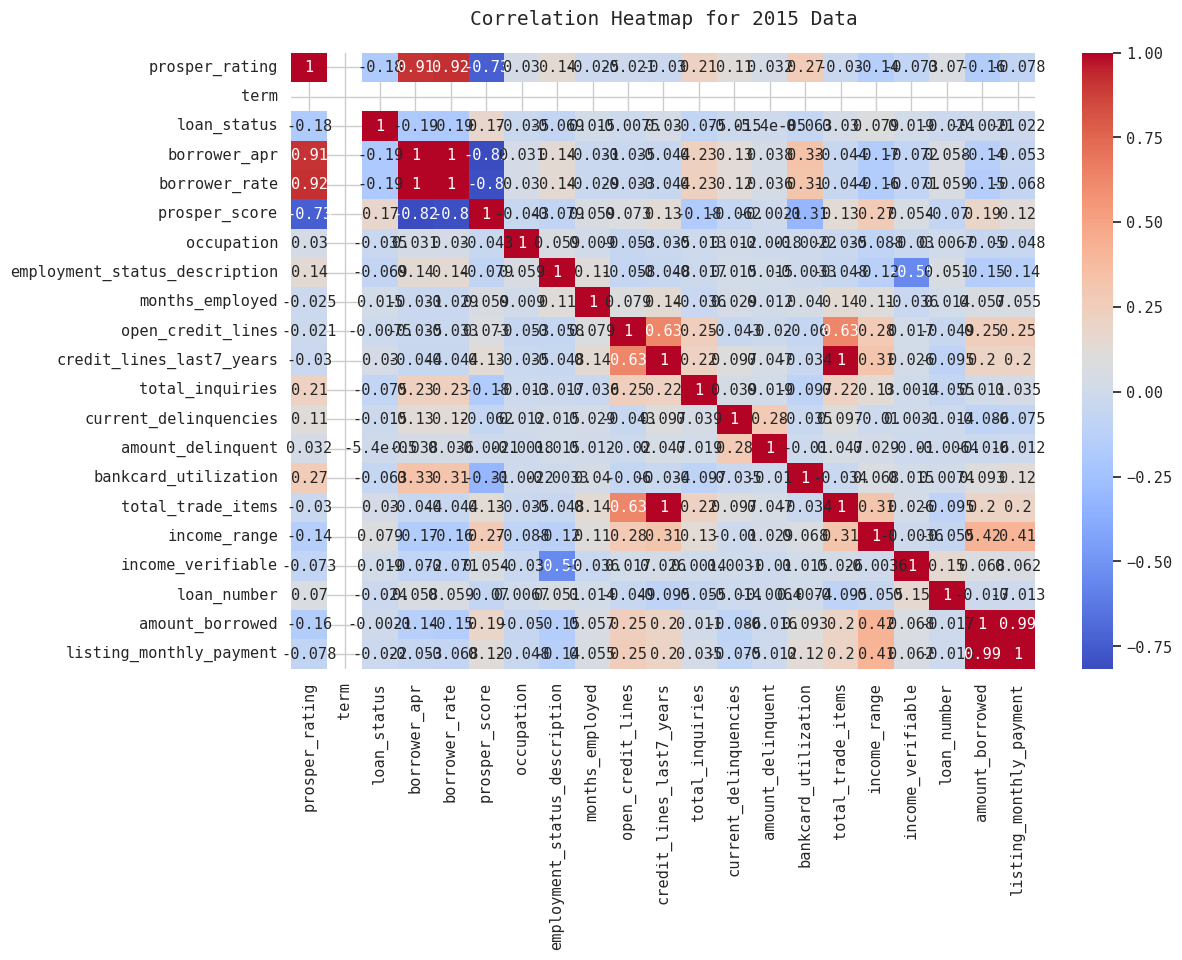

In [78]:
# Analyze relationships between features and target variable
plt.figure(figsize=(12, 8))
sns.heatmap(loans_2015.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for 2015 Data')
plt.show()


In [80]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split the data into training and testing sets
X_train = loans_2015.drop('loan_status', axis=1)
y_train = loans_2015['loan_status']
X_test = loans_2016.drop('loan_status', axis=1)
y_test = loans_2016['loan_status']

# Initialize model
model = GradientBoostingClassifier()

# Train each model on the training data
model.fit(X_train, y_train)

print(model)

GradientBoostingClassifier()


## Evaluate model's performance:

In [81]:
from sklearn.metrics import classification_report

# Evaluate model's performance on the training set
y_pred_train = model.predict(X_train)
print(classification_report(y_train, y_pred_train))
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision (Weighted):", precision_score(y_train, y_pred_train, average='weighted'))
print("Recall (Weighted):", recall_score(y_train, y_pred_train, average='weighted'))
print("F1 Score (Weighted):", f1_score(y_train, y_pred_train, average='weighted'))

##Model Evaluation:

# Test the model on 2016 dataset to simulate out-of-sample testing
y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision (Weighted):", precision_score(y_test, y_pred_test, average='weighted'))
print("Recall (Weighted):", recall_score(y_test, y_pred_test, average='weighted'))
print("F1 Score (Weighted):", f1_score(y_test, y_pred_test, average='weighted'))

              precision    recall  f1-score   support

           2       1.00      0.03      0.05      1315
           3       0.73      0.01      0.01     11154
           4       0.82      1.00      0.90     58168
           6       0.90      0.35      0.50       156

    accuracy                           0.82     70793
   macro avg       0.86      0.34      0.37     70793
weighted avg       0.81      0.82      0.75     70793

Accuracy: 0.8235418756091704
Precision (Weighted): 0.8122334499720362
Recall (Weighted): 0.8235418756091704
F1 Score (Weighted): 0.7460855135493153


C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saisu\anaconda3\Lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.02      0.00      0.00      2877
           3       0.18      0.12      0.15      7020
           4       0.84      0.92      0.88     48579
           6       0.00      0.00      0.00        75

    accuracy                           0.78     58552
   macro avg       0.21      0.21      0.21     58552
weighted avg       0.72      0.78      0.74     58552

Accuracy: 0.7780776062303594
Precision (Weighted): 0.7165646226339035
Recall (Weighted): 0.7780776062303594
F1 Score (Weighted): 0.7445698508824354


In [82]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = loans_2015.loc[:, loans_2015.columns != 'loan_status'], loans_2015['loan_status']

              precision    recall  f1-score   support

           2       0.00      0.10      0.01      1315
           3       0.18      0.01      0.01     11154
           4       0.81      0.26      0.39     58168
           6       0.00      0.00      0.00       156

    accuracy                           0.21     70793
   macro avg       0.25      0.09      0.10     70793
weighted avg       0.70      0.21      0.32     70793



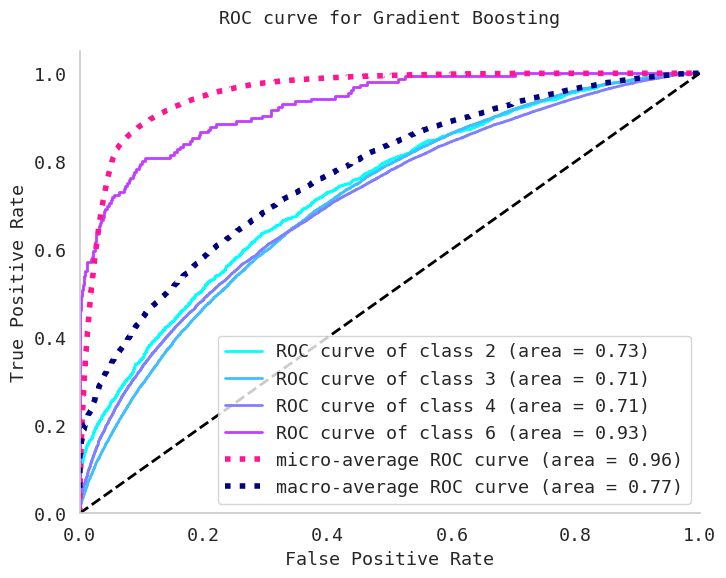

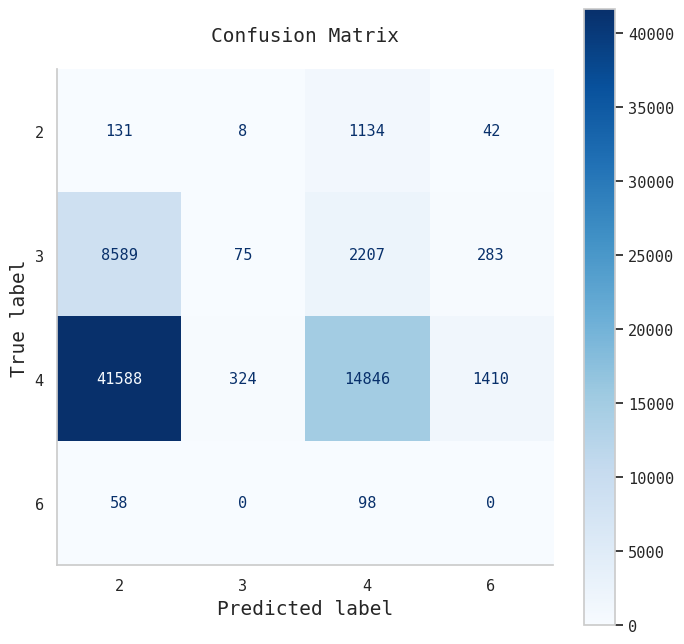

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
import joblib
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay
import scikitplot as skplt
from pathlib import Path
import os
import warnings

# Define the Gradient Boosting classifier
gradient_boosting = GradientBoostingClassifier(random_state=42)



# Function to get the y prediction
def y_prediction_func(model_trn):
    # Cross-validation prediction with kfold = 10
    y_cc_train_pred = cross_val_predict(model_trn, X_cc_train_prep, y_cc_train_prep, cv=10, n_jobs=-1)
    return y_cc_train_pred

# Function to plot the confusion matrix
def confusion_matrix_func(model_trn):
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep, y_prediction_func(model_trn), ax=ax, cmap='Blues', values_format='d')
    # Remove the grid
    plt.grid(visible=None)
    # Increase the font size of the x and y labels
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    # Give a title to the plot using the model name
    plt.title('Confusion Matrix', fontsize=14)
    # Show the plot
    plt.show()
    print('\n')

# Function to plot the ROC curve
def roc_curve_func(model_trn):
    # Check if y probabilities file exists, if not create it
    y_proba_path = Path('saved_models/gradient_boosting/y_cc_train_proba_gradient_boosting.sav')
    try:
        y_proba_path.resolve(strict=True)
    except FileNotFoundError:
        y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
        joblib.dump(y_cc_train_proba, y_proba_path)
    else:
        # If path exists, load the y probabilities file
        y_cc_train_proba = joblib.load(y_proba_path)
    skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba, title='ROC curve for Gradient Boosting', cmap='cool', figsize=(8, 6), text_fontsize='large')
    # Remove the grid
    plt.grid(visible=None)
    plt.show()
    print('\n')

# Function to display the classification report
def score_func(model_trn):
    class_report = classification_report(y_cc_train_prep, y_prediction_func(model_trn))
    print(class_report)

# Function to train the model
def train_model():
    # Check if the model file exists and if not create, train, and save it
    model_file_path = Path('saved_models/gradient_boosting/gradient_boosting_model.sav')
    try:
        model_file_path.resolve(strict=True)
    except FileNotFoundError:
        model_trn = gradient_boosting.fit(X_cc_train_prep, y_cc_train_prep)
        joblib.dump(model_trn, model_file_path)
        # Plot the most and least predictive features
        feat_importance_plot(model_trn)
        return model_trn
    else:
        # If path exists, load the model
        model_trn = joblib.load(model_file_path)
        return model_trn

# Check if the folder for saving the model exists, if not create it
if not os.path.exists('saved_models/gradient_boosting'):
    os.makedirs('saved_models/gradient_boosting')

# Train the model
model_trn = train_model()

# Print the scores from the classification report
score_func(model_trn)

# Plot the ROC curve
roc_curve_func(model_trn)

# Plot the confusion matrix
confusion_matrix_func(model_trn)

warnings.filterwarnings("ignore")
